# Information-Theoretic Benchmarking of Species Tree Inference

This notebook presents a comparative workflow for species tree inference using two different character sets: traditional amino acid sequences and foldtree-encoded structural features. The goal is to benchmark the phylogenetic signal carried by each character set using information-theoretic approaches.

**Workflow Overview:**
- Construct a species tree using a standard amino acid-based pipeline (multiple sequence alignment, concatenation, and maximum likelihood inference).
- Construct an equivalent species tree using foldtree-encoded data.
- For both trees, compute column-wise log-likelihoods and character frequencies.
- Quantify the information content and phylogenetic signal of each character set by analyzing the distribution of likelihoods and character frequencies.

This approach enables a direct comparison of how much evolutionary information is captured by sequence versus structure-based encodings, providing an objective benchmark for future phylogenomic analyses.

In [1]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [2]:
save_dir = './foldtree2/notebooks/benchmarks/Information_benchmark/'

In [3]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import requests
import random
import subprocess
from pathlib import Path
import concurrent.futures
import multiprocessing
import pandas as pd
import requests
from Bio import SeqIO
import re
import time

In [4]:
overwrite = False


In [5]:
import glob
markers = glob.glob( './families/Information_benchmark/marker_genes/marker_genes/*.fa')
print( f"Found {len(markers)} marker genes" )

Found 500 marker genes


In [6]:
#use autoreload to reload modules
%load_ext autoreload
%autoreload 2

In [7]:
# Specify your model and associated matrices
model = 'encoder_epoch_90'
from foldtree2 import ft2treebuilder as treebuilder
model_path = os.path.join( "models" , model )  # Path to your model (without .pkl)

model_file = model_path + ".pt"
mafftmat = model_path + "_mafftmat.mtx"
submat = model_path + "_submat.txt"
aapropcsv = os.path.join( 'foldtree2', "config" , "aaindex1.csv" )  # Path to your amino acid properties CSV file
# Initialize the treebuilder class
mafftmat = os.path.join(model_path + '_mafftmat.mtx')
submat = os.path.join(model_path + '_submat.txt')
charmaps = os.path.join(model_path + '_pair_counts.pkl')

tb = treebuilder.treebuilder(model=model_file, mafftmat=mafftmat, submat=submat , charmaps=charmaps, aapropcsv=aapropcsv ,  raxml_path='./foldtree2/raxml-ng/raxml-ng' ,
	 maffttext2hex='./foldtree2/mafft_tools/maffttext2hex', maffthex2text='./foldtree2/mafft_tools/hex2maffttext')

#check that the paths are correct
assert os.path.exists(tb.mafftmat), f"MAFFT matrix not found at {tb.mafftmat}"
assert os.path.exists(tb.submat), f"Substitution matrix not found at {tb.submat}"
#check the tools

assert os.path.exists(tb.raxml_path), f"RAxML-NG not found at {tb.raxml_path}"
assert os.path.exists(tb.maffttext2hex), f"MAFFT text to hex converter not found at {tb.maffttext2hex}"
assert os.path.exists(tb.maffthex2text), f"MAFFT hex to text converter not found at {tb.maffthex2text}"

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/se3_transformer_pytorch/irr_repr.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Jd = torch.load(str(path))


loading charmaps from models/encoder_epoch_90_pair_counts.pkl


In [8]:
import subprocess
import os

def run_raxml_lg_alignment(alignment_file, output_prefix="raxml_lg_tree", raxml_path="raxml-ng"):
	"""
	Run RAxML-NG on an amino acid alignment using the LG+G+I model.

	Parameters:
	-----------
	alignment_file : str
		Path to the aligned FASTA file (amino acid sequences)
	output_prefix : str
		Prefix for RAxML-NG output files
	raxml_path : str
		Path to the RAxML-NG executable (default: 'raxml-ng')

	Returns:
	--------
	str: Path to the inferred tree file (Newick format)
	"""
	tree_file = f"{output_prefix}.raxml.bestTree"
	cmd = [
		raxml_path,
		"--msa", alignment_file,
		"--model", "LG+G+I",
		"--prefix", output_prefix,
		"--threads", "1"
	]
	print(f"Running: {' '.join(cmd)}")
	subprocess.run(cmd, check=True)
	if os.path.exists(tree_file):
		print(f"Inferred tree saved to {tree_file}")
		return tree_file
	else:
		print("RAxML-NG did not produce a tree file.")
		return None

In [9]:
def align_fasta_with_mafft(fasta_file):
	"""
	Align a single FASTA file using MAFFT
	
	Parameters:
	-----------
	fasta_file : str
		Path to input FASTA file
	
	Returns:
	--------
	tuple: (input_path, output_path, success_status)
	"""
	# Create output filename - same directory but with .aligned.fa extension
	input_path = Path(fasta_file)
	output_path = input_path.with_name(f"{input_path.stem}.aligned.fa")
	
	# Run MAFFT
	cmd = f"mafft --auto --thread 1 {fasta_file} > {output_path}"
	print(f"Aligning: {fasta_file}")
	
	try:
		subprocess.run(cmd, shell=True, check=True, stderr=subprocess.PIPE)
		return (fasta_file, str(output_path), True)
	except subprocess.CalledProcessError as e:
		print(f"Error aligning {fasta_file}: {e}")
		return (fasta_file, str(output_path), False)

# Get number of available cores (leave 1 core free for system processes)
max_workers = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {max_workers} cores for alignments")

# Process alignments in parallel
aligned_files = []
failed_files = []


# Get number of available cores (leave 1 core free for system processes)
max_workers = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {max_workers} cores for alignments")
# Process alignments in parallel
aligned_files = []
failed_files = []

Using 31 cores for alignments
Using 31 cores for alignments


In [10]:
def extract_oma_ids_from_fasta(fasta_file):
	"""
	Extract OMA identifiers from a FASTA file
	ID format example:

	>MOUSE45461 | OMA754554 | COQ5_MOUSE | [Mus musculus]

	
	Parameters:
	-----------
	fasta_file : str
		Path to FASTA file
		
	Returns:
	--------
	list of str: OMA identifiers
	"""
	oma_ids = []
	oma_files = {}
	for record in SeqIO.parse(fasta_file, "fasta"):
		# Extract OMA ID from the FASTA header using the pipe-separated format
		id = record.description.split('|')[0]	
		oma_ids.append(id.strip())
	oma_files[id.strip()] = fasta_file
	return oma_ids , oma_files
# Extract OMA IDs from all marker files
oma_ids = []
oma_files = {}
for marker in markers:
	ids, files = extract_oma_ids_from_fasta(marker)
	oma_ids.extend(ids)
	oma_files.update(files)

oma_ids = list(set(oma_ids))  # Remove duplicates
print(f"Extracted {len(oma_ids)} unique OMA IDs from marker genes")
oma_files = pd.DataFrame.from_dict(oma_files, orient='index', columns=['fasta_file'])
oma_files.index.name = 'oma_id'
oma_files.reset_index(inplace=True)
oma_files.to_csv("oma_markergene_files.csv", index=False)


Extracted 8377 unique OMA IDs from marker genes


In [11]:
print( oma_ids[:10] )  # Print first 10 OMA IDs for verification

['PARTE30033', 'DROME18953', 'ARATH01149', 'PLAF704109', 'PARTE36064', 'CHLRE14680', 'DROME23844', 'CYAME03135', 'DICDI08033', 'PHYPA26333']


In [12]:
import json
import tqdm
def bulk_map_oma_to_uniprot(oma_ids, batch_size=100, retry_limit=3 , verbose=True):
	"""
	Map a list of OMA identifiers to UniProt using the OMA bulk API.

	Parameters:
	-----------
	oma_ids : list of str
		List of OMA identifiers (e.g., OMA123456)
	batch_size : int
		Number of IDs per batch (max 1000)
	retry_limit : int
		Number of times to retry on failure

	Returns:
	--------
	list of dict: Mapping information for each OMA ID
	"""
	url = "https://omabrowser.org/api/protein/bulk_retrieve/"
	all_results = []

	for i in tqdm.tqdm(range(0, len(oma_ids), batch_size)):
		batch = oma_ids[i:i+batch_size]
		for attempt in range(retry_limit):
			try:
				response = requests.post(url, json={"ids": batch})
				if response.ok:
					data = response.json()
					data = json.loads(response.text)  # Ensure we parse the JSON correctly
					#transfor data into dataframe
					results = {}
					for query in data:
						results[query['query_id']] = query['target']
					if verbose:
						print(f"Batch {i//batch_size+1} processed successfully with {len(results)} mappings")
						print(pd.DataFrame.from_dict(results, orient='index').reset_index())
					all_results.append(pd.DataFrame.from_dict(results, orient='index').reset_index())
					break  # Success, break retry loop
				else:
					print(f"Error fetching batch {i//batch_size+1}: HTTP {response.status_code}")
			except Exception as e:
				print(f"Error in batch {i//batch_size+1}: {str(e)}")
			time.sleep(1)
		else:
			# If all retries failed, add minimal info for each ID in the batch
			for oma_id in batch:
				all_results.append({'oma_id': oma_id, 'uniprot_id': None})
			all_results.append(pd.DataFrame([{'oma_id': oma_id, 'uniprot_id': None}]))
	# Concatenate all results into a single DataFrame
	if all_results:
		all_results = pd.concat(all_results, ignore_index=True)
		return all_results
	else:
		return pd.DataFrame(columns=['oma_id', 'uniprot_id'])


	

In [13]:
import os
# Check if the mapping file already exists
if not os.path.exists(save_dir):
	print(f"Creating directory {save_dir} for marker gene files...")
	os.makedirs(save_dir, exist_ok=True)


In [14]:
# Check if the mapping file already exists
mapping_file = os.path.join(save_dir, "oma_to_uniprot_mapping.csv")
if not os.path.exists(mapping_file):
	print("Mapping file does not exist, creating it now...")
	#retreive all OMA IDs from the marker genes
	mapping_df = bulk_map_oma_to_uniprot(oma_ids , verbose=False)
	# Save the mapping results to a CSV file
	mapping_df.to_csv(mapping_file, index=True)
else:
	print("Mapping file already exists, loading it...")
	mapping_df = pd.read_csv(mapping_file, index_col=0)
	print(f"Loaded mapping file with {len(mapping_df)} entries")
	print(mapping_df.head())
	

Mapping file already exists, loading it...
Loaded mapping file with 8377 entries
        index  entry_nr                                     entry_url  \
0  TRYB205898   7201087   https://omabrowser.org/api/protein/7201087/   
1  DROME24395  17556944  https://omabrowser.org/api/protein/17556944/   
2  YEAST00066   8927628   https://omabrowser.org/api/protein/8927628/   
3  THAPS06704  20296723  https://omabrowser.org/api/protein/20296723/   
4  DROME17519  17550068  https://omabrowser.org/api/protein/17550068/   

        omaid  canonicalid                      sequence_md5  sequence_length  \
0  TRYB205898       Q57ZU2  c077db9e5ee8aa5e763b0daf676859b6              860   
1  DROME24395   GATA_DROME  6f214dfc8f1dbf0393dd24e6aac8ea1a              508   
2  YEAST00066  HSP71_YEAST  7cdc576cd47040f8a215326a8e29e066              642   
3  THAPS06704       B8BYD7  c493f1360799e587e42ffc17c5f33a57             1103   
4  DROME17519       Q9VVI0  4827054d86ce99be2f09ad82c7666978              5

In [15]:

import pyoma.browser.db
db = pyoma.browser.db.Database("/home/dmoi/datasets/OMA/OmaServer.h5")
db.get_release_name()
resolver = pyoma.browser.db.IDResolver(db)
mapper = db.id_mapper['OMA']
linkout = db.id_mapper['Linkout'] 




Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/pyoma/browser/db.py", line 2340, in __init__
    self.seq_idx = self.seq_idx()
                   ^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/tables/link.py", line 427, in __call__
    self.extfile = tb.open_file(filename, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/pyoma/browser/db.py", line 137, in synchronized_open_file
    return _tables_file._original_open_file(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/tables/file.py", line 325, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/hom

In [16]:

entry = 'CHLRE00910'  # Example entry number
entry_nr = mapper.omaid_to_entry_nr(entry)
print(f"Entry number for {entry}: {entry_nr}")


Entry number for CHLRE00910: 20577393


In [17]:
#try mapping entry
entry = 'CHLRE00910'  # Example entry number
entry_nr = mapper.omaid_to_entry_nr(entry)
xrefs = linkout.iter_xrefs_for_entry_nr(entry_nr)
print([ r for r in xrefs])


[{'source': 'UniProtKB/TrEMBL', 'xref': 'A0A2K3DKT0', 'url': 'http://uniprot.org/uniprot/A0A2K3DKT0'}, {'source': 'EntrezGene', 'xref': '5718125', 'url': 'http://www.ncbi.nlm.nih.gov/gene/5718125'}]


In [18]:
def get_uniprot_ids_from_oma(oma_id, mapper, linkout):
	"""
	Get UniProt IDs for a given OMA ID by chaining mapper and xref operations.
	
	Parameters:
	-----------
	oma_id : str
		OMA identifier (e.g., 'CHLRE00910')
	mapper : pyoma.browser.db.OmaIdMapper
		OMA ID mapper instance
	linkout : pyoma.browser.idmapper.LinkoutIdMapper
		Linkout mapper instance
	
	Returns:
	--------
	list: UniProt IDs associated with the OMA ID
	"""
	try:
		# Convert OMA ID to entry number
		entry_nr = mapper.omaid_to_entry_nr(oma_id)
		
		# Get all xrefs for this entry
		xrefs = linkout.iter_xrefs_for_entry_nr(entry_nr)
		
		# Filter for UniProt references
		uniprot_ids = [ref['xref'] for ref in xrefs 
					  if ref['source'] in ['UniProtKB/Swiss-Prot', 'UniProtKB/TrEMBL']]
		
		return uniprot_ids
	
	except Exception as e:
		print(f"Error processing {oma_id}: {str(e)}")
		return []

# Test the function with the example entry
uniprot_ids = get_uniprot_ids_from_oma(entry, mapper, linkout)
print(f"UniProt IDs for {entry}: {uniprot_ids}")

UniProt IDs for CHLRE00910: ['A0A2K3DKT0']


In [19]:
print( mapping_df.head() )

        index  entry_nr                                     entry_url  \
0  TRYB205898   7201087   https://omabrowser.org/api/protein/7201087/   
1  DROME24395  17556944  https://omabrowser.org/api/protein/17556944/   
2  YEAST00066   8927628   https://omabrowser.org/api/protein/8927628/   
3  THAPS06704  20296723  https://omabrowser.org/api/protein/20296723/   
4  DROME17519  17550068  https://omabrowser.org/api/protein/17550068/   

        omaid  canonicalid                      sequence_md5  sequence_length  \
0  TRYB205898       Q57ZU2  c077db9e5ee8aa5e763b0daf676859b6              860   
1  DROME24395   GATA_DROME  6f214dfc8f1dbf0393dd24e6aac8ea1a              508   
2  YEAST00066  HSP71_YEAST  7cdc576cd47040f8a215326a8e29e066              642   
3  THAPS06704       B8BYD7  c493f1360799e587e42ffc17c5f33a57             1103   
4  DROME17519       Q9VVI0  4827054d86ce99be2f09ad82c7666978              553   

                                             species  oma_group  \
0  {'co

In [20]:
def ret_refs(oma_ids, mapper, linkout):
	"""
	Retrieve UniProt references for given OMA IDs from the OMA database.
	
	Parameters:
	-----------
	oma_ids : list
		List of OMA identifiers
	mapper : pyoma.browser.db.OmaIdMapper
		OMA ID mapper instance
	linkout : pyoma.browser.idmapper.LinkoutIdMapper
		Linkout mapper instance
	
	Returns:
	--------
	dict: Dictionary mapping OMA IDs to their UniProt references
	"""
	return {oma_id: get_uniprot_ids_from_oma(oma_id, mapper, linkout) for oma_id in oma_ids}

# Try with some OMA IDs
sample_oma_ids = mapping_df['index'].sample(10).tolist()
print(f"Sample OMA IDs: {sample_oma_ids}")

sample_refs = ret_refs(sample_oma_ids, mapper, linkout)
print("\nSample references:")
for oma_id, refs in sample_refs.items():
	print(f"{oma_id}: {refs}")

Sample OMA IDs: ['PLAF703305', 'THAPS06277', 'YEAST01688', 'YEAST04190', 'CAPO303433', 'DROME00680', 'YEAST01261', 'DROME17849', 'PARTE20823', 'NAEGR15208']

Sample references:
PLAF703305: ['O97250']
THAPS06277: ['B8BX57']
YEAST01688: ['P10363']
YEAST04190: ['A0A8H4BX66', 'Q12220']
CAPO303433: []
DROME00680: ['A0ANY9', 'A0ANZ0', 'Q9U5W4', 'Q9VM69']
YEAST01261: ['P32771']
DROME17849: ['Q9VF56']
PARTE20823: ['A0DMX1']
NAEGR15208: ['D2W197']


In [21]:
from collections import defaultdict
import pandas as pd

def parse_xref_list_to_row(xref_list):
	"""
	Parse a list of xref dicts into a single DataFrame row.
	Each xref source becomes a column, value is the xref (or list if multiple for same source).
	The row index is the OMA ID (omaid).
	
	Parameters:
	-----------
	xref_list : list of dict
		List of xref dictionaries as returned by the OMA API.
		
	Returns:
	--------
	pandas.DataFrame: Single-row DataFrame with omaid as index and xrefs as columns.
	"""

	if not xref_list:
		return pd.DataFrame()

	omaid = xref_list[0].get('omaid')
	xref_dict = defaultdict(list)
	for x in xref_list:
		src = x['source']
		xref_dict[src].append(x['xref'])

	# Flatten single-item lists
	xref_dict = {k: v[0] if len(v) == 1 else v for k, v in xref_dict.items()}
	xref_dict['omaid'] = omaid

	df = pd.DataFrame([xref_dict]).set_index('omaid')
	return df

In [22]:
mapping_path = os.path.join(save_dir, "oma_to_uniprot_mapping.csv")
mapping_df = pd.read_csv(mapping_path, index_col=0)
example = mapping_df.iloc[0]
print( example)
#use ret_refs to get xref
#check xref pickle
xref_path = os.path.join(save_dir, "xref_data.pkl")
# Check if the xref data pickle file exists
if os.path.exists(xref_path):
	print("Loading xref data from pickle file...")
	xref_data = pd.read_pickle(xref_path)
else:
	print("Xref data pickle not found, generating it...")
	# Generate xref data
	# This will take some time depending on the number of OMA IDs
	# and the speed of the OMA API
	xref_data = ret_refs(mapping_df.omaid.to_list() , mapper, linkout)
#map xref_data to a DataFrame
print(xref_data)

index                                                               TRYB205898
entry_nr                                                               7201087
entry_url                          https://omabrowser.org/api/protein/7201087/
omaid                                                               TRYB205898
canonicalid                                                             Q57ZU2
sequence_md5                                  c077db9e5ee8aa5e763b0daf676859b6
sequence_length                                                            860
species                      {'code': 'TRYB2', 'taxon_id': 185431, 'species...
oma_group                                                              1428576
oma_hog_id                                                     HOG:E0802393.2b
chromosome                                                                   5
locus                            {'start': 932578, 'end': 935160, 'strand': 1}
is_main_isoform                                     

In [23]:
mapping_df['uniprot_refs'] = mapping_df['omaid'].map(xref_data)

In [24]:
#save with uniprot_refs
map_out = os.path.join(save_dir, "oma_to_uniprot_mapping_with_refs.csv")
mapping_df.to_csv(map_out, index=False)

In [25]:
print( mapping_df.head() )

        index  entry_nr                                     entry_url  \
0  TRYB205898   7201087   https://omabrowser.org/api/protein/7201087/   
1  DROME24395  17556944  https://omabrowser.org/api/protein/17556944/   
2  YEAST00066   8927628   https://omabrowser.org/api/protein/8927628/   
3  THAPS06704  20296723  https://omabrowser.org/api/protein/20296723/   
4  DROME17519  17550068  https://omabrowser.org/api/protein/17550068/   

        omaid  canonicalid                      sequence_md5  sequence_length  \
0  TRYB205898       Q57ZU2  c077db9e5ee8aa5e763b0daf676859b6              860   
1  DROME24395   GATA_DROME  6f214dfc8f1dbf0393dd24e6aac8ea1a              508   
2  YEAST00066  HSP71_YEAST  7cdc576cd47040f8a215326a8e29e066              642   
3  THAPS06704       B8BYD7  c493f1360799e587e42ffc17c5f33a57             1103   
4  DROME17519       Q9VVI0  4827054d86ce99be2f09ad82c7666978              553   

                                             species  oma_group  \
0  {'co

In [26]:
mapping_df['1stref'] = mapping_df['uniprot_refs'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
#eliminate rows with no 1stref
mapping_df = mapping_df[mapping_df['1stref'].notnull()]
print(mapping_df.head())

        index  entry_nr                                     entry_url  \
0  TRYB205898   7201087   https://omabrowser.org/api/protein/7201087/   
1  DROME24395  17556944  https://omabrowser.org/api/protein/17556944/   
2  YEAST00066   8927628   https://omabrowser.org/api/protein/8927628/   
3  THAPS06704  20296723  https://omabrowser.org/api/protein/20296723/   
4  DROME17519  17550068  https://omabrowser.org/api/protein/17550068/   

        omaid  canonicalid                      sequence_md5  sequence_length  \
0  TRYB205898       Q57ZU2  c077db9e5ee8aa5e763b0daf676859b6              860   
1  DROME24395   GATA_DROME  6f214dfc8f1dbf0393dd24e6aac8ea1a              508   
2  YEAST00066  HSP71_YEAST  7cdc576cd47040f8a215326a8e29e066              642   
3  THAPS06704       B8BYD7  c493f1360799e587e42ffc17c5f33a57             1103   
4  DROME17519       Q9VVI0  4827054d86ce99be2f09ad82c7666978              553   

                                             species  oma_group  \
0  {'co

In [27]:
mapping_df['struct_folder'] = mapping_df['oma_group'].apply(lambda x: f"./families/Information_benchmark/marker_genes/{x}/structs")

In [28]:
from foldtree2.src.AFDB_tools import grab_struct
import tqdm

In [30]:
dl = False
if dl == True:
	#download the alphafold structures for each marker gene family
	for idx,row in tqdm.tqdm(mapping_df.iterrows()):
		#check if the folder exists
		struct_folder = row['struct_folder']
		if not os.path.exists(struct_folder):
			os.makedirs(struct_folder)
		else:
			#clear struct folder
			if overwrite:
				files = os.listdir(struct_folder)
				for f in files:
					os.remove( os.path.join(struct_folder, f) )
		#download the structure
		retpath = grab_struct(row['1stref'], struct_folder, overwrite=overwrite)
		#add struct path to mapping_df
		mapping_df.at[idx, 'struct_path'] = retpath
	#save the mapping_df with struct paths
	map_out = os.path.join(save_dir, "oma_to_uniprot_mapping_with_structs.csv")
	mapping_df.to_csv(map_out, index=False)
else:
	#load the mapping_df with struct paths
	map_out = os.path.join(save_dir, "oma_to_uniprot_mapping_with_structs.csv")
	mapping_df = pd.read_csv(map_out)

In [31]:
#drop the rows with no struct_path
mapping_df = mapping_df[mapping_df['struct_path'].notnull()]
print(f"Final mapping DataFrame with structures: {mapping_df.shape[0]} entries")

Final mapping DataFrame with structures: 7536 entries


In [32]:
#write an identifier file for each marker gene family
for sub in mapping_df['oma_group'].unique():
	sub_df = mapping_df[mapping_df['oma_group'] == sub]
	#write the uniprot ids to an identifiers.txt file
	identifiers_file = f"./families/Information_benchmark/marker_genes/{sub}/identifiers.txt"
	with open(identifiers_file, 'w') as f:
		for uniprot_id in sub_df['1stref'].unique():
			f.write(f"{uniprot_id}\n")

In [33]:
from Bio import PDB

def create_fasta_from_pdbs(pdb_folder, output_fasta, chain_id='A', species_mapping=None):
	"""
	Create a FASTA file from PDB structures by extracting amino acid sequences using Biopython.
	
	Parameters:
	-----------
	pdb_folder : str
		Path to folder containing PDB files
	output_fasta : str
		Path to output FASTA file
	chain_id : str, optional
		Chain ID to extract sequence from (default: 'A')
	species_mapping : dict, optional
		Dictionary mapping PDB IDs to species codes
		
	Returns:
	--------
	list: List of SeqRecord objects that were written to FASTA
	"""
	
	# Standard amino acid 3-letter to 1-letter conversion
	aa_codes = {
		'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
		'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
		'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
		'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
		'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
	}
	
	records = []
	parser = PDB.PDBParser(QUIET=True)
	
	# Find all PDB files in the folder
	pdb_files = glob.glob(os.path.join(pdb_folder, "*.pdb"))
	
	for pdb_file in pdb_files:
		try:
			# Get structure name from filename
			pdb_id = os.path.basename(pdb_file).replace('.pdb', '')
			
			# Parse structure
			structure = parser.get_structure(pdb_id, pdb_file)
			
			# Get first model
			model = structure[0]
			
			# Check if requested chain exists
			if chain_id in model:
				chain = model[chain_id]
				
				# Extract sequence
				sequence = ''
				for residue in chain:
					if residue.get_resname() in aa_codes:
						sequence += aa_codes[residue.get_resname()]
				
				if sequence:
					# Create record ID with species code if available
					if species_mapping and pdb_id in species_mapping:
						record_id = f"{pdb_id}|{species_mapping[pdb_id]}"
						description = f"Chain {chain_id} sequence from {pdb_file} - Species: {species_mapping[pdb_id]}"
					else:
						record_id = pdb_id
						description = f"Chain {chain_id} sequence from {pdb_file}"
					
					# Create SeqRecord object
					record = SeqRecord(
						Seq(sequence),
						id=record_id,
						description=description
					)
					records.append(record)
			
		except Exception as e:
			print(f"Error processing {pdb_file}: {str(e)}")
	
	# Write all sequences to FASTA file
	if records:
		with open(output_fasta, 'w') as handle:
			SeqIO.write(records, handle, 'fasta')
		print(f"Created FASTA file with {len(records)} sequences at {output_fasta}")
	else:
		print("No sequences were extracted from PDB files")
	
	return records

In [34]:
#create a FASTA file for each marker gene family and use the species mapping from the sub datafram

for sub in mapping_df['oma_group'].unique():
	sub_df = mapping_df[mapping_df['oma_group'] == sub]
	struct_folder = sub_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
	output_fasta = f"./families/Information_benchmark/marker_genes/{sub}/sequences.fasta"
	
	# Create species mapping for this family
	species_mapping = dict( (zip(sub_df['1stref'], sub_df['omaid'].apply(lambda x: x[:5]))) )
	if not os.path.exists(output_fasta):
		print(f"Creating FASTA file for {sub} in {output_fasta}")
		create_fasta_from_pdbs(struct_folder, output_fasta, chain_id='A', species_mapping=species_mapping)
	else:
		print(f"FASTA file already exists for {sub}, skipping creation")

FASTA file already exists for 1428576, skipping creation
FASTA file already exists for 966408, skipping creation
FASTA file already exists for 1067505, skipping creation
FASTA file already exists for 1314601, skipping creation
FASTA file already exists for 1067338, skipping creation
FASTA file already exists for 848449, skipping creation
FASTA file already exists for 1392015, skipping creation
FASTA file already exists for 756269, skipping creation
FASTA file already exists for 1344491, skipping creation
FASTA file already exists for 1372179, skipping creation
FASTA file already exists for 1067608, skipping creation
FASTA file already exists for 1324983, skipping creation
FASTA file already exists for 1427916, skipping creation
FASTA file already exists for 1067292, skipping creation
FASTA file already exists for 1384924, skipping creation
FASTA file already exists for 770664, skipping creation
FASTA file already exists for 1396383, skipping creation
FASTA file already exists for 10132

In [35]:
 #use normal mafft to align the sequences
import glob
from concurrent.futures import ThreadPoolExecutor
aln = False
if aln:
	# Get all FASTA files in the marker gene families
	fasta_files = glob.glob("./families/Information_benchmark/marker_genes/*/sequences.fasta")
	print(f"Found {len(fasta_files)} FASTA files for alignment")
	# Align all FASTA files in parallel
	max_workers = 10  # Leave 1 core free for system processes

	with ThreadPoolExecutor(max_workers=max_workers) as executor:
		results = list(executor.map(align_fasta_with_mafft, tqdm.tqdm(fasta_files)))

In [ ]:
#for each marker gene, encode the structs, align and make a tree using treebuilder
import foldtree2 as ft2

overwrite = True

for fam in tqdm.tqdm(mapping_df['oma_group'].unique()):
	fam_df = mapping_df[mapping_df['oma_group'] == fam]
	#check if the folder exists
	struct_folder = fam_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
	#check if the aligned file exists
	outfile = f"./families/Information_benchmark/marker_genes/{fam}/encoded.ASCIIaln.txt.raxml.bestTree"
	outdir = os.path.dirname(outfile)
	if not os.path.exists(outfile) or overwrite:
		outfasta = os.path.join(outdir, 'encoded.fasta')
		print(f"Encoding structures for {fam} into {outfasta}")
		
		try:	
			results = tb.structs2tree( structs=struct_folder+'/*.pdb' , outdir=outdir, overwrite=overwrite, mafftmat=mafftmat, submat=submat, aapropcsv=aapropcsv )
			#results is a dictionary with keys 'encoded_fasta', 'tree', 'alignment', 'mafft_aln', 'asciifile', 'hexfasta'
			encoded_fasta = results['encoded_fasta']
			treefile = results['tree']
			alnfasta = results['alignment']
			mafftaln = results['mafft_aln']
			asciifile = results['asciifile']
			hexfasta = results['hexfasta']
			print(f"Encoded FASTA: {encoded_fasta}")
			print(f"Tree file: {treefile}")
			print(f"Alignment FASTA: {alnfasta}")
			print(f"MAFFT alignment: {mafftaln}")
			print(f"ASCII file: {asciifile}")
			print(f"Hex FASTA: {hexfasta}")
		except Exception as e:
			print(f"Error processing {fam}: {str(e)}")
			continue
	else:
		print(f"Output file {outfile} already exists, skipping encoding for {fam}")

  0%|                                                   | 0/500 [00:00<?, ?it/s]

Encoding structures for 1428576 into ./families/Information_benchmark/marker_genes/1428576/encoded.fasta


converting structures


















100%|███████████████████████████████████████████| 15/15 [00:36<00:00,  2.46s/it]
Encoding structures to FASTA: 15it [00:36,  2.46s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1428576/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1428576/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1428576/encoded.hex > ./families/Information_benchmark/marker_genes/1428576/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1428576/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1428576/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1428576/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    13 /14 (thread   10) 
Reallocating (by thread 14) ..done. *alloclen = 3325
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1-1379
006-0026-1 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1428576/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1428576/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1428576/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1428576/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  0%|                                       | 1/500 [01:48<14:59:33, 108.16s/it]

[00:00:57] [worker #1] Bootstrap tree #18, logLikelihood: -31570.058771

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:18<00:00,  1.21s/it]
Encoding structures to FASTA: 15it [00:18,  1.21s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/966408/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/966408/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/966408/encoded.hex > ./families/Information_benchmark/marker_genes/966408/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/966408/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/966408/encoded.ASCII  > ./families/Information_benchmark/marker_genes/966408/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     6 /14 (thread    7) 
Reallocating (by thread 15) ..done. *alloclen = 2130
STEP    14 /14 (thread    8) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 689
007-0026-0 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/966408/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/966408/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/966408/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/966408/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  0%|▏                                       | 2/500 [02:37<10:10:38, 73.57s/it]

[00:00:26] [worker #0] Bootstrap tree #1, logLikelihood: -18220.393415

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.0213

converting structures
















100%|███████████████████████████████████████████| 13/13 [00:22<00:00,  1.70s/it]
Encoding structures to FASTA: 13it [00:22,  1.70s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067505/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067505/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067505/encoded.hex > ./families/Information_benchmark/marker_genes/1067505/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067505/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067505/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067505/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP    10 /12 (thread    8) 
Reallocating (by thread 9) ..done. *alloclen = 2363
STEP    12 /12 (thread   12) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1- 717
004-0022-0 (thread    6)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067505/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067505/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067505/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067505/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  1%|▏                                        | 3/500 [03:18<8:07:02, 58.80s/it]

[00:00:14] [worker #10] Bootstrap tree #11, logLikelihood: -12142.419705
[00:00:14] [worker #19] Bootstrap tree #20, logLikelihood: -12212.167811
[00:00:14] [worker #12] Bootstrap tree #13, logLikelihood: -11500.579023
[00:00:15] [worker #7] Bootstrap tree #8, logLikelihood: -12187.454835
[00:00:15] [worker #6] Bootstrap tree #7, logLikelihood: -12527.373502

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.02

converting structures

















100%|███████████████████████████████████████████| 14/14 [01:08<00:00,  4.89s/it]
Encoding structures to FASTA: 14it [01:08,  4.89s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1314601/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1314601/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1314601/encoded.hex > ./families/Information_benchmark/marker_genes/1314601/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1314601/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1314601/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1314601/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 14
done.

Progressive alignment ... 
STEP    13 /13 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 14
Segment   1/  1    1-1713
005-0024-1 (thread    5) worse         001-0002-1 (thread    6) identical     001-0004-1 (thread    6) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1314601/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1314601/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1314601/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1314601/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  1%|▎                                       | 4/500 [05:23<11:40:25, 84.73s/it]

[00:00:43] [worker #8] Bootstrap tree #19, logLikelihood: -37137.864374

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures

















100%|███████████████████████████████████████████| 14/14 [00:21<00:00,  1.55s/it]
Encoding structures to FASTA: 14it [00:21,  1.55s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067338/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067338/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067338/encoded.hex > ./families/Information_benchmark/marker_genes/1067338/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067338/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067338/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067338/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 14
done.

Progressive alignment ... 
STEP    12 /13 (thread   11) 
Reallocating (by thread 13) ..done. *alloclen = 2822
STEP    13 /13 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 14
Segment   1/  1    1-1205
004-0024-1 (thread    4

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067338/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067338/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067338/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067338/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  1%|▍                                       | 5/500 [06:21<10:19:36, 75.10s/it]

[00:00:30] [worker #2] Bootstrap tree #19, logLikelihood: -20565.556168

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:21<00:00,  1.40s/it]
Encoding structures to FASTA: 15it [00:21,  1.40s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/848449/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/848449/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/848449/encoded.hex > ./families/Information_benchmark/marker_genes/848449/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/848449/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/848449/encoded.ASCII  > ./families/Information_benchmark/marker_genes/848449/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     7 /14 (thread    3) 
Reallocating (by thread 10) ..done. *alloclen = 2150
STEP    14 /14 (thread    8) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 692
004-0026-0 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/848449/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/848449/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/848449/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/848449/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  1%|▍                                        | 6/500 [07:13<9:13:17, 67.20s/it]

[00:00:26] [worker #2] Bootstrap tree #3, logLikelihood: -19959.905839
[00:00:26] [worker #12] Bootstrap tree #13, logLikelihood: -19624.888506

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:07<00:00,  1.99it/s]
Encoding structures to FASTA: 15it [00:07,  1.99it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1392015/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1392015/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1392015/encoded.hex > ./families/Information_benchmark/marker_genes/1392015/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1392015/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1392015/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1392015/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     5 /14 (thread    1) 
Reallocating (by thread 4) ..done. *alloclen = 1571
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 318
003-0026-1 (thread    2)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1392015/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1392015/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1392015/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1392015/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  1%|▌                                        | 7/500 [07:36<7:14:12, 52.85s/it]

[00:00:13] [worker #8] Bootstrap tree #9, logLikelihood: -8444.562418
[00:00:13] [worker #17] Bootstrap tree #18, logLikelihood: -8487.291171

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.01787

converting structures

















100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it]
Encoding structures to FASTA: 14it [00:56,  4.02s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/756269/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/756269/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/756269/encoded.hex > ./families/Information_benchmark/marker_genes/756269/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/756269/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/756269/encoded.ASCII  > ./families/Information_benchmark/marker_genes/756269/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 14
done.

Progressive alignment ... 
STEP    12 /13 (thread   13) 
Reallocating (by thread 10) ..done. *alloclen = 3614
STEP    13 /13 (thread   10) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 14
Segment   1/  1    1-1571
003-0024-1 (thread    4

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/756269/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/756269/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/756269/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/756269/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  2%|▋                                        | 8/500 [09:24<9:37:30, 70.43s/it]

[00:00:43] [worker #0] Bootstrap tree #17, logLikelihood: -32879.123869

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:46<00:00,  3.11s/it]
Encoding structures to FASTA: 15it [00:46,  3.11s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1344491/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1344491/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1344491/encoded.hex > ./families/Information_benchmark/marker_genes/1344491/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1344491/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1344491/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1344491/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     8 /14 (thread    4) 
Reallocating (by thread 11) ..done. *alloclen = 2979
STEP    14 /14 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1-1198
008-0026-1 (thread    2

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1344491/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1344491/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1344491/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1344491/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  2%|▋                                       | 9/500 [11:08<11:03:19, 81.06s/it]

[00:00:44] [worker #1] Bootstrap tree #18, logLikelihood: -30107.671129
[00:00:45] [worker #2] Bootstrap tree #19, logLikelihood: -31471.513094

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]
Encoding structures to FASTA: 16it [00:19,  1.22s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1372179/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1372179/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1372179/encoded.hex > ./families/Information_benchmark/marker_genes/1372179/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1372179/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1372179/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1372179/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    10 /15 (thread    2) 
Reallocating (by thread 6) ..done. *alloclen = 2094
STEP    15 /15 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 590
003-0028-1 (thread    7)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1372179/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1372179/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1372179/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1372179/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  2%|▊                                       | 10/500 [11:54<9:31:53, 70.03s/it]

[00:00:22] [worker #10] Bootstrap tree #11, logLikelihood: -11986.278650
[00:00:22] [worker #11] Bootstrap tree #12, logLikelihood: -11684.015422

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.0

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:21<00:00,  1.35s/it]
Encoding structures to FASTA: 16it [00:21,  1.35s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067608/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067608/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067608/encoded.hex > ./families/Information_benchmark/marker_genes/1067608/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067608/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067608/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067608/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    14 /15 (thread   13) 
Reallocating (by thread 12) ..done. *alloclen = 2227
STEP    15 /15 (thread   12) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 689
002-0028-1 (thread    7

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067608/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067608/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067608/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067608/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  2%|▉                                       | 11/500 [12:45<8:44:26, 64.35s/it]

Encoding structures for 1324983 into ./families/Information_benchmark/marker_genes/1324983/encoded.fasta


converting structures


















100%|███████████████████████████████████████████| 15/15 [00:07<00:00,  1.99it/s]
Encoding structures to FASTA: 15it [00:07,  1.99it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1324983/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1324983/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1324983/encoded.hex > ./families/Information_benchmark/marker_genes/1324983/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1324983/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1324983/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1324983/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    11 /14 (thread    9) 
Reallocating (by thread 13) ..done. *alloclen = 1635
STEP    14 /14 (thread   10) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 359
004-0026-1 (thread    7

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1324983/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1324983/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1324983/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1324983/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  2%|▉                                       | 12/500 [13:09<7:02:48, 51.99s/it]

[00:00:13] [worker #11] Bootstrap tree #12, logLikelihood: -10640.285452
[00:00:13] [worker #17] Bootstrap tree #18, logLikelihood: -10395.581301

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.0

converting structures
















100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]
Encoding structures to FASTA: 13it [00:02,  4.74it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1427916/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1427916/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1427916/encoded.hex > ./families/Information_benchmark/marker_genes/1427916/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1427916/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1427916/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1427916/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP     3 /12 (thread    4) 
Reallocating (by thread 0) ..done. *alloclen = 1252
STEP    12 /12 (thread   11) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1- 141
003-0022-1 (thread    8)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1427916/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1427916/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1427916/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1427916/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  3%|█                                       | 13/500 [13:19<5:18:38, 39.26s/it]

[00:00:05] [worker #3] Bootstrap tree #4, logLikelihood: -3257.992322

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02137

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:16<00:00,  1.03it/s]
Encoding structures to FASTA: 17it [00:16,  1.03it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067292/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067292/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067292/encoded.hex > ./families/Information_benchmark/marker_genes/1067292/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067292/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067292/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067292/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP     6 /16 (thread    5) 
Reallocating (by thread 7) ..done. *alloclen = 1709
STEP    16 /16 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 408
003-0030-1 (thread    7)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067292/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067292/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067292/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067292/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  3%|█                                       | 14/500 [13:58<5:17:28, 39.19s/it]

[00:00:19] [worker #12] Bootstrap tree #13, logLikelihood: -12159.360133

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.34it/s]
Encoding structures to FASTA: 16it [00:06,  2.34it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1384924/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1384924/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1384924/encoded.hex > ./families/Information_benchmark/marker_genes/1384924/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1384924/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1384924/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    15 /15 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 226
003-0028-1 (thread    5) identical     002-0011-1 (thread    1) identical     
Converged.

Converged2.
don

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  3%|█▏                                      | 15/500 [14:19<4:31:33, 33.60s/it]

treefile: ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt.raxml.bestTree

                  /-L8GXX4
               /-|
              |   \-Q8ILV2
              |
            /-|   /-Q54J69
           |  |  |
           |  |  |      /-Q09533
           |   \-|     |
           |     |   /-|      /-I1G756
           |     |  |  |   /-|
           |     |  |   \-|   \-A2AM97
           |      \-|     |
         /-|        |      \-M9PIM0
        |  |        |
        |  |        |   /-A0A0D2UEG9
        |  |         \-|
        |  |           |   /-A0A6A5PUZ5
      /-|  |            \-|
     |  |  |               \-Q7S7F0
     |  |  |
     |  |   \-A0A178W7N6
   /-|  |
  |  |  |   /-Q38EC5
  |  |   \-|
  |  |      \-A0BIC4
--|  |
  |   \-D2VA92
  |
  |--B8C3Y3
  |
   \-D8LFF2
Encoded FASTA: ./families/Information_benchmark/marker_genes/1384924/encoded.fasta
Tree file: ./families/Information_benchmark/marker_genes/1384924/encoded.ASCIIaln.txt.raxml.bestTree
Alig

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:59<00:00,  3.50s/it]
Encoding structures to FASTA: 17it [00:59,  3.50s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/770664/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/770664/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/770664/encoded.hex > ./families/Information_benchmark/marker_genes/770664/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/770664/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/770664/encoded.ASCII  > ./families/Information_benchmark/marker_genes/770664/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    11 /16 (thread   12) 
Reallocating (by thread 10) ..done. *alloclen = 2992
STEP    16 /16 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1-1208
006-0030-1 (thread    4

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/770664/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/770664/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/770664/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/770664/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  3%|█▎                                      | 16/500 [16:33<8:36:28, 64.03s/it]

[00:01:03] [worker #1] Bootstrap tree #18, logLikelihood: -32560.795734

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures



















100%|███████████████████████████████████████████| 17/17 [00:11<00:00,  1.42it/s]
Encoding structures to FASTA: 17it [00:11,  1.42it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1396383/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1396383/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1396383/encoded.hex > ./families/Information_benchmark/marker_genes/1396383/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1396383/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1396383/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1396383/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    12 /16 (thread    7) 
Reallocating (by thread 13) ..done. *alloclen = 1883
STEP    16 /16 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 534
003-0030-0 (thread    2

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1396383/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1396383/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1396383/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1396383/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  3%|█▎                                      | 17/500 [17:15<7:40:48, 57.24s/it]

[00:00:26] [worker #10] Bootstrap tree #11, logLikelihood: -15590.221740

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:24<00:00,  1.62s/it]
Encoding structures to FASTA: 15it [00:24,  1.62s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1013205/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1013205/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1013205/encoded.hex > ./families/Information_benchmark/marker_genes/1013205/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1013205/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1013205/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1013205/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    13 /14 (thread   10) 
Reallocating (by thread 12) ..done. *alloclen = 2750
STEP    14 /14 (thread   12) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1-1129
006-0026-0 (thread    7

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1013205/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1013205/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1013205/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1013205/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  4%|█▍                                      | 18/500 [18:27<8:16:49, 61.85s/it]

[00:00:39] [worker #1] Bootstrap tree #18, logLikelihood: -24349.424963

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures











100%|█████████████████████████████████████████████| 8/8 [00:41<00:00,  5.20s/it]
Encoding structures to FASTA: 8it [00:41,  5.20s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1321861/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1321861/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1321861/encoded.hex > ./families/Information_benchmark/marker_genes/1321861/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1321861/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1321861/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1321861/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
    0 / 8
done.

Progressive alignment ... 
STEP     5 /7 (thread    6) 
Reallocating (by thread 2) ..done. *alloclen = 3867
STEP     7 /7 (thread    5) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

    0 / 8
Segment   1/  1    1-1620
006-0012-1 (thread    3) wor

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1321861/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1321861/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1321861/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1321861/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  4%|█▌                                      | 19/500 [19:31<8:21:05, 62.51s/it]

[00:00:12] [worker #8] Bootstrap tree #19, logLikelihood: -29012.324566

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures
















100%|███████████████████████████████████████████| 13/13 [00:11<00:00,  1.10it/s]
Encoding structures to FASTA: 13it [00:11,  1.09it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067522/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067522/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067522/encoded.hex > ./families/Information_benchmark/marker_genes/1067522/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067522/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067522/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067522/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP    11 /12 (thread   10) 
Reallocating (by thread 13) ..done. *alloclen = 2047
STEP    12 /12 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1- 597
005-0022-0 (thread    4

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067522/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067522/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067522/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067522/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  4%|█▌                                      | 20/500 [20:02<7:04:23, 53.05s/it]

[00:00:15] [worker #0] Bootstrap tree #1, logLikelihood: -10518.335055

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.0213

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:32<00:00,  2.15s/it]
Encoding structures to FASTA: 15it [00:32,  2.15s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1428549/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1428549/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1428549/encoded.hex > ./families/Information_benchmark/marker_genes/1428549/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1428549/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1428549/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1428549/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    10 /14 (thread    9) 
Reallocating (by thread 12) ..done. *alloclen = 2669
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 910
004-0026-1 (thread    1

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1428549/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1428549/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1428549/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1428549/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  4%|█▋                                      | 21/500 [21:24<8:11:32, 61.57s/it]

[00:00:43] [worker #2] Bootstrap tree #19, logLikelihood: -24298.380598

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.74it/s]
Encoding structures to FASTA: 15it [00:04,  3.74it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1408429/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1408429/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1408429/encoded.hex > ./families/Information_benchmark/marker_genes/1408429/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1408429/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1408429/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1408429/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     9 /14 (thread    7) 
Reallocating (by thread 4) ..done. *alloclen = 1423
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 243
007-0026-1 (thread    2)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1408429/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1408429/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1408429/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1408429/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  4%|█▊                                      | 22/500 [21:42<6:25:41, 48.41s/it]

[00:00:11] [worker #18] Bootstrap tree #19, logLikelihood: -6129.774758

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures

















100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.45it/s]
Encoding structures to FASTA: 15it [00:06,  2.44it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067331/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067331/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067331/encoded.hex > ./families/Information_benchmark/marker_genes/1067331/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067331/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067331/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067331/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    12 /14 (thread   13) 
Reallocating (by thread 11) ..done. *alloclen = 1560
STEP    14 /14 (thread   12) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 341
003-0026-1 (thread    3

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067331/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067331/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067331/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067331/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  5%|█▊                                      | 23/500 [22:02<5:18:05, 40.01s/it]

[00:00:12] [worker #17] Bootstrap tree #18, logLikelihood: -6008.749912

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:12<00:00,  1.41it/s]
Encoding structures to FASTA: 17it [00:12,  1.41it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/866568/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/866568/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/866568/encoded.hex > ./families/Information_benchmark/marker_genes/866568/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/866568/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/866568/encoded.ASCII  > ./families/Information_benchmark/marker_genes/866568/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    11 /16 (thread    8) 
Reallocating (by thread 14) ..done. *alloclen = 1806
STEP    16 /16 (thread   11) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 452
003-0030-1 (thread    3

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/866568/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/866568/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/866568/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/866568/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  5%|█▉                                      | 24/500 [22:36<5:03:30, 38.26s/it]

[00:00:19] [worker #1] Bootstrap tree #2, logLikelihood: -11132.856405

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.0213

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.90it/s]
Encoding structures to FASTA: 17it [00:05,  2.89it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1415986/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1415986/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1415986/encoded.hex > ./families/Information_benchmark/marker_genes/1415986/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1415986/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1415986/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1415986/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    16 /16 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 265
003-0030-0 (thread    2) identical     001-0026-1 (thread    8) identical     003-0000-1 (thread    3) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1415986/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1415986/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1415986/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1415986/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  5%|██                                      | 25/500 [22:59<4:26:41, 33.69s/it]

[00:00:14] [worker #9] Bootstrap tree #10, logLikelihood: -6846.296571

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.0213

converting structures





















100%|███████████████████████████████████████████| 18/18 [00:50<00:00,  2.82s/it]
Encoding structures to FASTA: 18it [00:50,  2.82s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1428602/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1428602/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1428602/encoded.hex > ./families/Information_benchmark/marker_genes/1428602/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1428602/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1428602/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1428602/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 18
done.

Progressive alignment ... 
STEP    14 /17 (thread   15) 
Reallocating (by thread 11) ..done. *alloclen = 3346
STEP    17 /17 (thread    2) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 18
Segment   1/  1    1-1447
005-0032-1 (thread    5

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1428602/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1428602/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1428602/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1428602/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  5%|██                                      | 26/500 [25:32<9:09:43, 69.58s/it]

[00:01:29] [worker #0] Bootstrap tree #17, logLikelihood: -41775.216973

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures
















100%|███████████████████████████████████████████| 13/13 [00:30<00:00,  2.34s/it]
Encoding structures to FASTA: 13it [00:30,  2.34s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/880796/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/880796/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/880796/encoded.hex > ./families/Information_benchmark/marker_genes/880796/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/880796/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/880796/encoded.ASCII  > ./families/Information_benchmark/marker_genes/880796/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP    12 /12 (thread   10) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1-1146
005-0022-1 (thread    2) identical     001-0003-0 (thread    1) identical     001-0006-0 (thread    5) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/880796/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/880796/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/880796/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/880796/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  5%|██▏                                     | 27/500 [26:45<9:15:19, 70.44s/it]

[00:00:33] [worker #2] Bootstrap tree #19, logLikelihood: -23377.035997

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures





















100%|███████████████████████████████████████████| 18/18 [00:08<00:00,  2.24it/s]
Encoding structures to FASTA: 18it [00:08,  2.24it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1353941/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1353941/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1353941/encoded.hex > ./families/Information_benchmark/marker_genes/1353941/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1353941/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1353941/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1353941/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 18
done.

Progressive alignment ... 
STEP    16 /17 (thread   14) 
Reallocating (by thread 1) ..done. *alloclen = 1525
STEP    17 /17 (thread    1) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 18
Segment   1/  1    1- 265
002-0032-1 (thread    1)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1353941/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1353941/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1353941/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1353941/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  6%|██▏                                     | 28/500 [27:09<7:25:57, 56.69s/it]

[00:00:14] [worker #5] Bootstrap tree #6, logLikelihood: -6738.353223
[00:00:14] [worker #14] Bootstrap tree #15, logLikelihood: -6579.613095

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.01787

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:30<00:00,  1.91s/it]
Encoding structures to FASTA: 16it [00:30,  1.91s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1377727/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1377727/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1377727/encoded.hex > ./families/Information_benchmark/marker_genes/1377727/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1377727/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1377727/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1377727/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP     8 /15 (thread    9) 
Reallocating (by thread 13) ..done. *alloclen = 2769
STEP    15 /15 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1-1244
005-0028-1 (thread    3

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1377727/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1377727/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1377727/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1377727/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  6%|██▎                                     | 29/500 [28:32<8:26:13, 64.49s/it]

[00:00:44] [worker #0] Bootstrap tree #17, logLikelihood: -25573.870407

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures






















100%|███████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]
Encoding structures to FASTA: 20it [00:23,  1.18s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1425268/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1425268/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1425268/encoded.hex > ./families/Information_benchmark/marker_genes/1425268/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1425268/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1425268/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1425268/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 20
done.

Progressive alignment ... 
STEP    17 /19 (thread    4) 
Reallocating (by thread 9) ..done. *alloclen = 2291
STEP    19 /19 (thread    1) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 20
Segment   1/  1    1- 820
003-0036-0 (thread    8)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1425268/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1425268/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1425268/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1425268/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  6%|██▍                                     | 30/500 [30:01<9:21:25, 71.67s/it]

[00:00:59] [worker #12] Bootstrap tree #13, logLikelihood: -20331.286502

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:18<00:00,  1.06s/it]
Encoding structures to FASTA: 17it [00:18,  1.06s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1323557/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1323557/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1323557/encoded.hex > ./families/Information_benchmark/marker_genes/1323557/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1323557/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1323557/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1323557/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    16 /16 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 641
004-0030-1 (thread    2) worse         001-0011-1 (thread    5) identical     001-0021-1 (thread    5) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1323557/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1323557/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1323557/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1323557/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  6%|██▍                                     | 31/500 [30:47<8:22:00, 64.22s/it]

[00:00:24] [worker #0] Bootstrap tree #1, logLikelihood: -13744.542052
[00:00:24] [worker #18] Bootstrap tree #19, logLikelihood: -13771.619232

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:57<00:00,  3.83s/it]
Encoding structures to FASTA: 15it [00:57,  3.83s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1401951/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1401951/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1401951/encoded.hex > ./families/Information_benchmark/marker_genes/1401951/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1401951/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1401951/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1401951/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     6 /14 (thread    5) 
Reallocating (by thread 7) ..done. *alloclen = 3324
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1-1609
008-0026-1 (thread    5)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1401951/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1401951/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1401951/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1401951/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  6%|██▍                                    | 32/500 [32:51<10:39:27, 81.98s/it]

[00:00:48] [worker #1] Bootstrap tree #12, logLikelihood: -40066.635656
[00:00:48] [worker #4] Bootstrap tree #15, logLikelihood: -39840.627698

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:09<00:00,  1.52it/s]
Encoding structures to FASTA: 15it [00:09,  1.52it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1304109/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1304109/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1304109/encoded.hex > ./families/Information_benchmark/marker_genes/1304109/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1304109/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1304109/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1304109/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    11 /14 (thread   11) 
Reallocating (by thread 10) ..done. *alloclen = 1802
STEP    14 /14 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 495
004-0026-0 (thread    2

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1304109/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1304109/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1304109/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1304109/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  7%|██▋                                     | 33/500 [33:23<8:40:35, 66.89s/it]

[00:00:18] [worker #7] Bootstrap tree #8, logLikelihood: -11722.999245

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.0213

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:42<00:00,  2.68s/it]
Encoding structures to FASTA: 16it [00:42,  2.68s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1301229/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1301229/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1301229/encoded.hex > ./families/Information_benchmark/marker_genes/1301229/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1301229/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1301229/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1301229/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    12 /15 (thread   10) 
Reallocating (by thread 12) ..done. *alloclen = 3138
STEP    15 /15 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1-1316
007-0028-0 (thread    4

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1301229/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1301229/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1301229/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1301229/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  7%|██▋                                     | 34/500 [35:03<9:58:28, 77.06s/it]

[00:00:46] [worker #3] Bootstrap tree #20, logLikelihood: -31430.632541

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures



















100%|███████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]
Encoding structures to FASTA: 16it [00:06,  2.39it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1427648/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1427648/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1427648/encoded.hex > ./families/Information_benchmark/marker_genes/1427648/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1427648/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1427648/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1427648/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    15 /15 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 274
004-0028-1 (thread    4) worse         002-0000-0 (thread    1) identical     003-0004-1 (thread    2) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1427648/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1427648/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1427648/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1427648/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  7%|██▊                                     | 35/500 [35:26<7:51:09, 60.79s/it]

[00:00:14] [worker #0] Bootstrap tree #1, logLikelihood: -6007.290923

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02137

converting structures

















100%|███████████████████████████████████████████| 14/14 [00:25<00:00,  1.83s/it]
Encoding structures to FASTA: 14it [00:25,  1.83s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067288/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067288/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067288/encoded.hex > ./families/Information_benchmark/marker_genes/1067288/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067288/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067288/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067288/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 14
done.

Progressive alignment ... 
STEP     8 /13 (thread    8) 
Reallocating (by thread 7) ..done. *alloclen = 2598
STEP    13 /13 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 14
Segment   1/  1    1- 937
004-0024-0 (thread    1)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067288/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067288/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067288/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067288/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  7%|██▉                                     | 36/500 [36:31<7:59:12, 61.97s/it]

[00:00:33] [worker #2] Bootstrap tree #19, logLikelihood: -22664.006180

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]
Encoding structures to FASTA: 15it [00:08,  1.75it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1366871/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1366871/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1366871/encoded.hex > ./families/Information_benchmark/marker_genes/1366871/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1366871/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1366871/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1366871/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     8 /14 (thread   10) 
Reallocating (by thread 3) ..done. *alloclen = 1754
STEP    14 /14 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 545
005-0026-0 (thread    3)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1366871/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1366871/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1366871/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1366871/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  7%|██▉                                     | 37/500 [37:01<6:43:23, 52.27s/it]


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021377 0.024364 0.024942 0.025929 0.029272 0.017052 0.020056 0.016570 0.044

converting structures
















100%|███████████████████████████████████████████| 13/13 [00:20<00:00,  1.57s/it]
Encoding structures to FASTA: 13it [00:20,  1.57s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067353/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067353/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067353/encoded.hex > ./families/Information_benchmark/marker_genes/1067353/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067353/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067353/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067353/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP    11 /12 (thread   13) 
Reallocating (by thread 10) ..done. *alloclen = 2720
STEP    12 /12 (thread   10) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1-1057
005-0022-1 (thread    6

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067353/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067353/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067353/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067353/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  8%|███                                     | 38/500 [37:51<6:39:04, 51.83s/it]

[00:00:24] [worker #3] Bootstrap tree #20, logLikelihood: -21678.773935

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.021

converting structures

















100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.33it/s]
Encoding structures to FASTA: 15it [00:03,  4.32it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/910085/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/910085/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/910085/encoded.hex > ./families/Information_benchmark/marker_genes/910085/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/910085/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/910085/encoded.ASCII  > ./families/Information_benchmark/marker_genes/910085/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    11 /14 (thread   10) 
Reallocating (by thread 11) ..done. *alloclen = 1283
STEP    14 /14 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 148
002-0026-1 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/910085/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/910085/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/910085/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/910085/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  8%|███                                     | 39/500 [38:04<5:07:53, 40.07s/it]

[00:00:07] [worker #13] Bootstrap tree #14, logLikelihood: -2059.248979
[00:00:07] [worker #18] Bootstrap tree #19, logLikelihood: -2043.683294

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:06<00:00,  2.17it/s]
Encoding structures to FASTA: 15it [00:06,  2.16it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/770707/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/770707/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/770707/encoded.hex > ./families/Information_benchmark/marker_genes/770707/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/770707/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/770707/encoded.ASCII  > ./families/Information_benchmark/marker_genes/770707/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP     9 /14 (thread    6) 
Reallocating (by thread 8) ..done. *alloclen = 1601
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 342
003-0026-1 (thread    6)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/770707/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/770707/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/770707/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/770707/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

  8%|███▏                                    | 40/500 [38:27<4:28:57, 35.08s/it]

[00:00:14] [worker #7] Bootstrap tree #8, logLikelihood: -7734.574478

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02137

converting structures




















100%|███████████████████████████████████████████| 17/17 [00:15<00:00,  1.11it/s]
Encoding structures to FASTA: 17it [00:15,  1.11it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1067352/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1067352/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1067352/encoded.hex > ./families/Information_benchmark/marker_genes/1067352/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1067352/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1067352/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1067352/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 17
done.

Progressive alignment ... 
STEP    11 /16 (thread   10) 
Reallocating (by thread 11) ..done. *alloclen = 2037
STEP    16 /16 (thread   15) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 17
Segment   1/  1    1- 746
005-0030-0 (thread    2

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1067352/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1067352/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1067352/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1067352/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  8%|███▎                                    | 41/500 [39:21<5:10:29, 40.59s/it]

[00:00:32] [worker #11] Bootstrap tree #12, logLikelihood: -17975.935858

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02

converting structures

















100%|███████████████████████████████████████████| 14/14 [00:04<00:00,  2.83it/s]
Encoding structures to FASTA: 14it [00:04,  2.82it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1375210/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1375210/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1375210/encoded.hex > ./families/Information_benchmark/marker_genes/1375210/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1375210/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 14
done.

Progressive alignment ... 
STEP    13 /13 (thread   13) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 14
Segment   1/  1    1- 296
003-0024-1 (thread    1) identical     002-0001-1 (thread    1) identical     003-0014-0 (thread    6) ide

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  8%|███▎                                    | 42/500 [39:40<4:21:43, 34.29s/it]

treefile: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.raxml.bestTree

               /-A0A178UQS1
            /-|
         /-|   \-A9TBI7
        |  |
      /-|   \-Q8SYD7
     |  |
     |  |   /-X6LX77
     |   \-|
   /-|     |   /-Q584X7
  |  |      \-|
  |  |         \-Q55D55
  |  |
  |  |   /-D7G6E1
  |   \-|
  |      \-B8C9M3
--|
  |   /-P40206
  |--|
  |   \-Q7SCC7
  |
  |      /-D2VGU7
  |   /-|
  |  |   \-Q9XW03
   \-|
     |   /-A0PK78
      \-|
         \-Q86WR0
Encoded FASTA: ./families/Information_benchmark/marker_genes/1375210/encoded.fasta
Tree file: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.raxml.bestTree
Alignment FASTA: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.raxml_aln.fasta
MAFFT alignment: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCIIaln.txt.hex
ASCII file: ./families/Information_benchmark/marker_genes/1375210/encoded.ASCII
Hex FASTA: ./families/In

converting structures

















100%|███████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]
Encoding structures to FASTA: 15it [00:17,  1.18s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1428356/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1428356/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1428356/encoded.hex > ./families/Information_benchmark/marker_genes/1428356/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1428356/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1428356/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    12 /14 (thread   12) 
Reallocating (by thread 13) ..done. *alloclen = 2409
STEP    14 /14 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 881
005-0026-1 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  9%|███▍                                    | 43/500 [40:33<5:03:59, 39.91s/it]

Best ML tree saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.bestTree
All ML trees saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.mlTrees
Best ML tree with Felsenstein bootstrap (FBP) support values saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.support
Optimized model saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.bestModel
Bootstrap trees saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.bootstraps

Execution log saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428356/encoded.ASCIIaln.txt.raxml.log

Analysis started: 23-Oct-2025 17:04:15 / finished: 23-Oct-2025 17:04:45

Elapsed time: 29.974 seconds

converting structures


















100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.14it/s]
Encoding structures to FASTA: 15it [00:04,  3.14it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1407616/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1407616/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1407616/encoded.hex > ./families/Information_benchmark/marker_genes/1407616/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1407616/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1407616/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1407616/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 15
done.

Progressive alignment ... 
STEP    10 /14 (thread    5) 
Reallocating (by thread 10) ..done. *alloclen = 1413
STEP    14 /14 (thread   11) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 15
Segment   1/  1    1- 209
002-0026-1 (thread    8

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1407616/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1407616/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1407616/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1407616/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  9%|███▌                                    | 44/500 [40:49<4:08:42, 32.72s/it]

[00:00:09] [worker #17] Bootstrap tree #18, logLikelihood: -4926.828684
[00:00:09] [worker #8] Bootstrap tree #9, logLikelihood: -4758.365806

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.01787

converting structures



















100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.04it/s]
Encoding structures to FASTA: 16it [00:02,  6.02it/s]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/1327813/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/1327813/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/1327813/encoded.hex > ./families/Information_benchmark/marker_genes/1327813/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/1327813/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/1327813/encoded.ASCII  > ./families/Information_benchmark/marker_genes/1327813/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    13 /15 (thread   11) 
Reallocating (by thread 13) ..done. *alloclen = 1280
STEP    15 /15 (thread   14) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 157
003-0028-0 (thread    5

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/1327813/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/1327813/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/1327813/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/1327813/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum

  9%|███▌                                    | 45/500 [41:05<3:29:19, 27.60s/it]

[00:00:10] [worker #5] Bootstrap tree #6, logLikelihood: -4960.251089

Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: NONE
   Base frequencies (user): 0.011208 0.027031 0.058819 0.052557 0.018617 0.015729 0.039371 0.006839 0.006819 0.010859 0.021168 0.020166 0.027214 0.020599 0.009649 0.022378 0.076429 0.020272 0.002760 0.007051 0.041174 0.035085 0.047783 0.017096 0.014366 0.027318 0.009194 0.005869 0.007569 0.059720 0.043131 0.026461 0.016305 0.049871 0.021521 0.020480 0.017492 0.009585 0.012845 0.041601 
   Substitution rates (user): 0.025019 0.025812 0.047600 0.030488 0.016649 0.018842 0.028241 0.014901 0.028567 0.021099 0.027165 0.035050 0.015550 0.033462 0.023011 0.021669 0.055965 0.012300 0.034703 0.029756 0.015681 0.020317 0.029896 0.033692 0.033516 0.024792 0.019547 0.045416 0.031351 0.023933 0.015693 0.012319 0.064452 0.018238 0.056928 0.027093 0.102993 0.051630 0.027070 0.017879 0.017935 0.022833 0.030037 0.019862 0.021647 0.036979 0.031458 0.02137

converting structures
















100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.45s/it]
Encoding structures to FASTA: 13it [00:18,  1.45s/it]


converting to hex for mafft
outfile for hex : ./families/Information_benchmark/marker_genes/882256/encoded.hex
converting to ascii for mafft
outfile for ascii : ./families/Information_benchmark/marker_genes/882256/encoded.ASCII
./foldtree2/mafft_tools/hex2maffttext ./families/Information_benchmark/marker_genes/882256/encoded.hex > ./families/Information_benchmark/marker_genes/882256/encoded.ASCII
asciifile: ./families/Information_benchmark/marker_genes/882256/encoded.ASCII
running mafft
mafft --text --thread -1 --localpair --maxiterate 1000 --textmatrix models/encoder_epoch_90_mafftmat.mtx ./families/Information_benchmark/marker_genes/882256/encoded.ASCII  > ./families/Information_benchmark/marker_genes/882256/encoded.ASCIIaln.txt


OS = linux
The number of physical cores =  16
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
16 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 13
done.

Progressive alignment ... 
STEP     8 /12 (thread    3) 
Reallocating (by thread 8) ..done. *alloclen = 2470
STEP    12 /12 (thread   11) 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
16 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 8
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 13
Segment   1/  1    1- 962
005-0022-0 (thread    1)

converting mafft aln to hex fasta
./foldtree2/mafft_tools/maffttext2hex ./families/Information_benchmark/marker_genes/882256/encoded.ASCIIaln.txt > ./families/Information_benchmark/marker_genes/882256/encoded.ASCIIaln.txt.hex
running raxml-ng
./foldtree2/raxml-ng/raxml-ng --model MULTI40_GTR{models/encoder_epoch_90_submat.txt} --redo  --all --bs-trees 20 --seed 12345 --threads auto{32} --workers auto --msa ./families/Information_benchmark/marker_genes/882256/encoded.ASCIIaln.txt.raxml_aln.fasta --prefix ./families/Information_benchmark/marker_genes/882256/encoded.ASCIIaln.txt --force perf_threads

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/rax

In [38]:
import glob
import os
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [46]:
#glob up all the sequence alignments
alignment_files = glob.glob("./families/Information_benchmark/marker_genes/*/aligned.fasta")
#glob up all the structural alignments
structural_alignment_files = glob.glob("./families/Information_benchmark/marker_genes/*/encoded.ASCIIaln.txt.raxml_aln.fasta")

In [ ]:
#create a tree for each marker gene using raxml and mafft in normal mode

for fam in tqdm.tqdm(mapping_df['oma_group'].unique()):
	fam_df = mapping_df[mapping_df['oma_group'] == fam]
	#check if the folder exists
	#check if the raxml tree already exists
	raxml_tree_file = f"./families/Information_benchmark/marker_genes/{fam}/raxml_lg_tree.raxml.bestTree"
	if not os.path.exists( f"./families/Information_benchmark/marker_genes/{fam}/raxml" ):
		struct_folder = fam_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
		#pdb fasta 
		output_fasta = f"./families/Information_benchmark/marker_genes/{fam}/sequences.fasta"
		alnfast = align_fasta_with_mafft(output_fasta)[1]  # Get the aligned FASTA file path
		if alnfast is None:
			print(f"Alignment failed for {output_fasta}, skipping tree creation for {fam}")
			continue
		
		print(f"Creating RAxML tree for {fam} using aligned FASTA: {alnfast}")
		# Run RAxML-LG alignment and tree inference
		# Use the output prefix to save the tree file
		raxml_ng_path = "./foldtree2/raxml-ng/raxml-ng"
		tree = run_raxml_lg_alignment(alnfast, output_prefix=f"./families/Information_benchmark/marker_genes/{fam}/raxml_lg_tree", raxml_path=raxml_ng_path)

  0%|                                                                     | 0/500 [00:00<?, ?it/s]

Aligning: ./families/Information_benchmark/marker_genes/1428576/sequences.fasta
Creating RAxML tree for 1428576 using aligned FASTA: families/Information_benchmark/marker_genes/1428576/sequences.aligned.fa
Running: ./foldtree2/raxml-ng/raxml-ng --msa families/Information_benchmark/marker_genes/1428576/sequences.aligned.fa --model LG+G+I --prefix ./families/Information_benchmark/marker_genes/1428576/raxml_lg_tree --threads 1

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 20-Aug-2025 12:11:11 as follows:

./foldtree2/raxml-ng/raxml-ng --msa famil

  0%|                                                         | 1/500 [02:26<20:20:45, 146.79s/it]

All ML trees saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428576/raxml_lg_tree.raxml.mlTrees
Optimized model saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428576/raxml_lg_tree.raxml.bestModel

Execution log saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/1428576/raxml_lg_tree.raxml.log

Analysis started: 20-Aug-2025 12:11:11 / finished: 20-Aug-2025 12:13:33

Elapsed time: 141.513 seconds

Inferred tree saved to ./families/Information_benchmark/marker_genes/1428576/raxml_lg_tree.raxml.bestTree
Aligning: ./families/Information_benchmark/marker_genes/966408/sequences.fasta
Creating RAxML tree for 966408 using aligned FASTA: families/Information_benchmark/marker_genes/966408/sequences.aligned.fa
Running: ./foldtree2/raxml-ng/raxml-ng --msa families/Information_benchmark/marker_genes/966408/sequences.aligned.fa --model LG+G+I --prefix ./families/Information_benchmark/marker_gen

  0%|▏                                                        | 2/500 [03:48<15:02:19, 108.71s/it]

[00:01:20 -13663.158059] SLOW spr round 3 (radius: 15)
[00:01:20 -13663.158058] Model parameter optimization (eps = 0.100000)

[00:01:20] ML tree search #20, logLikelihood: -13663.157974


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.260802 (ML),  weights&rates: (0.250000,0.185899) (0.250000,0.543209) (0.250000,1.032631) (0.250000,2.238261) 
   P-inv (ML): 0.051430
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  1%|▎                                                         | 3/500 [04:30<10:48:19, 78.27s/it]

[00:00:41 -7929.039719] Model parameter optimization (eps = 0.100000)

[00:00:41] ML tree search #20, logLikelihood: -7929.035479


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.833069 (ML),  weights&rates: (0.250000,0.102574) (0.250000,0.420115) (0.250000,0.965713) (0.250000,2.511599) 
   P-inv (ML): 0.206759
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238

  1%|▍                                                        | 4/500 [06:59<14:36:36, 106.04s/it]

[00:02:24 -27317.160545] Model parameter optimization (eps = 0.100000)

[00:02:24] ML tree search #20, logLikelihood: -27317.107798


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.419552 (ML),  weights&rates: (0.250000,0.212623) (0.250000,0.574594) (0.250000,1.045326) (0.250000,2.167457) 
   P-inv (ML): 0.072716
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  1%|▌                                                        | 5/500 [08:42<14:25:40, 104.93s/it]

[00:01:40 -15995.060391] Model parameter optimization (eps = 0.100000)

[00:01:40] ML tree search #20, logLikelihood: -15995.060224


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.668925 (ML),  weights&rates: (0.250000,0.250278) (0.250000,0.614455) (0.250000,1.058974) (0.250000,2.076293) 
   P-inv (ML): 0.020842
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  1%|▋                                                         | 6/500 [10:02<13:14:17, 96.47s/it]

[00:01:18 -14129.999032] SLOW spr round 3 (radius: 15)
[00:01:18 -14129.999032] Model parameter optimization (eps = 0.100000)

[00:01:18] ML tree search #20, logLikelihood: -14129.998820


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.591991 (ML),  weights&rates: (0.250000,0.239190) (0.250000,0.603185) (0.250000,1.055396) (0.250000,2.102229) 
   P-inv (ML): 0.043435
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  1%|▊                                                         | 7/500 [10:42<10:40:01, 77.89s/it]


[00:00:38] ML tree search #20, logLikelihood: -6253.886677


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.253244 (ML),  weights&rates: (0.250000,0.184569) (0.250000,0.541570) (0.250000,1.031921) (0.250000,2.241940) 
   P-inv (ML): 0.063528
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.0006

  2%|▉                                                         | 8/500 [12:54<13:01:48, 95.34s/it]

[00:02:07 -23187.250154] Model parameter optimization (eps = 0.100000)

[00:02:07] ML tree search #20, logLikelihood: -23187.166812


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.036115 (ML),  weights&rates: (0.250000,0.144103) (0.250000,0.487344) (0.250000,1.005735) (0.250000,2.362817) 
   P-inv (ML): 0.023533
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  2%|█                                                         | 9/500 [14:38<13:22:42, 98.09s/it]

[00:01:40 -21927.142206] Model parameter optimization (eps = 0.100000)

[00:01:40] ML tree search #20, logLikelihood: -21927.137791


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.835160 (ML),  weights&rates: (0.250000,0.272771) (0.250000,0.636256) (0.250000,1.065259) (0.250000,2.025714) 
   P-inv (ML): 0.033615
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  2%|█▏                                                       | 10/500 [15:34<11:33:53, 84.97s/it]

[00:00:54 -7507.847897] SLOW spr round 3 (radius: 15)
[00:00:54 -7507.847890] Model parameter optimization (eps = 0.100000)

[00:00:54] ML tree search #20, logLikelihood: -7507.752232


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.517121 (ML),  weights&rates: (0.250000,0.036603) (0.250000,0.262946) (0.250000,0.832337) (0.250000,2.868113) 
   P-inv (ML): 0.140171
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  2%|█▎                                                       | 11/500 [17:00<11:35:44, 85.37s/it]

[00:01:24 -12906.995350] SLOW spr round 3 (radius: 15)
[00:01:24 -12906.994942] Model parameter optimization (eps = 0.100000)

[00:01:24] ML tree search #20, logLikelihood: -12906.994279


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.815390 (ML),  weights&rates: (0.250000,0.270196) (0.250000,0.633828) (0.250000,1.064601) (0.250000,2.031376) 
   P-inv (ML): 0.007764
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  2%|█▎                                                       | 12/500 [17:48<10:01:04, 73.90s/it]

[00:00:46 -8260.986224] SLOW spr round 3 (radius: 15)
[00:00:46 -8260.986224] Model parameter optimization (eps = 0.100000)

[00:00:46] ML tree search #20, logLikelihood: -8260.986206


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.417164 (ML),  weights&rates: (0.250000,0.338460) (0.250000,0.693121) (0.250000,1.077623) (0.250000,1.890796) 
   P-inv (ML): 0.035287
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  3%|█▌                                                        | 13/500 [18:01<7:29:27, 55.37s/it]

[00:00:12 -2244.456888] SLOW spr round 2 (radius: 10)
[00:00:12 -2244.456679] Model parameter optimization (eps = 0.100000)

[00:00:12] ML tree search #20, logLikelihood: -2244.456090


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.823449 (ML),  weights&rates: (0.250000,0.100538) (0.250000,0.416406) (0.250000,0.963246) (0.250000,2.519809) 
   P-inv (ML): 0.000000
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  3%|█▌                                                        | 14/500 [19:03<7:45:21, 57.45s/it]

[00:01:01 -9515.365337] SLOW spr round 3 (radius: 15)
[00:01:01 -9515.365311] Model parameter optimization (eps = 0.100000)

[00:01:01] ML tree search #20, logLikelihood: -9515.329370


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.261331 (ML),  weights&rates: (0.250000,0.185992) (0.250000,0.543324) (0.250000,1.032681) (0.250000,2.238004) 
   P-inv (ML): 0.013895
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  3%|█▋                                                        | 15/500 [19:29<6:27:04, 47.89s/it]

[00:00:25 -4200.931861] SLOW spr round 3 (radius: 15)
[00:00:25 -4200.931059] Model parameter optimization (eps = 0.100000)

[00:00:25] ML tree search #20, logLikelihood: -4200.900007


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.804591 (ML),  weights&rates: (0.250000,0.096535) (0.250000,0.408976) (0.250000,0.958219) (0.250000,2.536270) 
   P-inv (ML): 0.202881
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  3%|█▊                                                       | 16/500 [22:16<11:16:26, 83.86s/it]


[00:02:42] ML tree search #20, logLikelihood: -24699.114422


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.365374 (ML),  weights&rates: (0.250000,0.203756) (0.250000,0.564498) (0.250000,1.041430) (0.250000,2.190316) 
   P-inv (ML): 0.022328
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000

  3%|█▉                                                       | 17/500 [23:33<10:56:56, 81.61s/it]

[00:01:15 -12398.595414] SLOW spr round 3 (radius: 15)
[00:01:15 -12398.595413] Model parameter optimization (eps = 0.100000)

[00:01:15] ML tree search #20, logLikelihood: -12398.595317


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.231950 (ML),  weights&rates: (0.250000,0.319475) (0.250000,0.677611) (0.250000,1.074841) (0.250000,1.928073) 
   P-inv (ML): 0.017550
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  4%|██                                                       | 18/500 [25:22<12:03:45, 90.09s/it]

[00:01:46 -18830.462786] SLOW spr round 3 (radius: 15)
[00:01:46 -18830.462778] Model parameter optimization (eps = 0.100000)

[00:01:47] ML tree search #20, logLikelihood: -18830.462519


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.336164 (ML),  weights&rates: (0.250000,0.198868) (0.250000,0.558802) (0.250000,1.039153) (0.250000,2.203177) 
   P-inv (ML): 0.033076
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  4%|██▏                                                      | 19/500 [26:13<10:28:14, 78.37s/it]

[00:00:47 -23000.781499] Model parameter optimization (eps = 0.100000)

[00:00:47] ML tree search #20, logLikelihood: -23000.754070


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.128711 (ML),  weights&rates: (0.250000,0.308170) (0.250000,0.668038) (0.250000,1.072900) (0.250000,1.950892) 
   P-inv (ML): 0.021426
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  4%|██▎                                                       | 20/500 [26:43<8:30:31, 63.82s/it]

[00:00:28 -6805.936052] SLOW spr round 2 (radius: 10)
[00:00:29 -6805.936051] Model parameter optimization (eps = 0.100000)

[00:00:29] ML tree search #20, logLikelihood: -6805.931293


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.878346 (ML),  weights&rates: (0.250000,0.112089) (0.250000,0.436864) (0.250000,0.976505) (0.250000,2.474543) 
   P-inv (ML): 0.220457
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  4%|██▍                                                      | 21/500 [28:29<10:09:52, 76.39s/it]

[00:01:43 -18427.150536] SLOW spr round 3 (radius: 15)
[00:01:43 -18427.150530] Model parameter optimization (eps = 0.100000)

[00:01:44] ML tree search #20, logLikelihood: -18427.144041


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.465108 (ML),  weights&rates: (0.250000,0.219882) (0.250000,0.582644) (0.250000,1.048305) (0.250000,2.149169) 
   P-inv (ML): 0.042440
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  4%|██▌                                                       | 22/500 [28:56<8:10:59, 61.63s/it]

[00:00:26 -4509.293947] SLOW spr round 3 (radius: 15)
[00:00:26 -4509.293946] Model parameter optimization (eps = 0.100000)

[00:00:26] ML tree search #20, logLikelihood: -4509.292906


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.549637 (ML),  weights&rates: (0.250000,0.232889) (0.250000,0.596615) (0.250000,1.053208) (0.250000,2.117287) 
   P-inv (ML): 0.070836
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  5%|██▋                                                       | 23/500 [29:30<7:02:32, 53.15s/it]

[00:00:32 -4480.970290] SLOW spr round 3 (radius: 15)
[00:00:32 -4480.970181] Model parameter optimization (eps = 0.100000)

[00:00:32] ML tree search #20, logLikelihood: -4480.504786


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.724418 (ML),  weights&rates: (0.250000,0.079410) (0.250000,0.374827) (0.250000,0.933592) (0.250000,2.612172) 
   P-inv (ML): 0.000000
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  5%|██▊                                                       | 24/500 [30:25<7:07:54, 53.94s/it]

[00:00:54 -7808.307658] SLOW spr round 3 (radius: 15)
[00:00:54 -7808.307650] Model parameter optimization (eps = 0.100000)

[00:00:54] ML tree search #20, logLikelihood: -7808.215314


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.012431 (ML),  weights&rates: (0.250000,0.139428) (0.250000,0.480457) (0.250000,1.002030) (0.250000,2.378086) 
   P-inv (ML): 0.038392
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  5%|██▉                                                       | 25/500 [30:59<6:18:35, 47.82s/it]

[00:00:32 -4563.626889] SLOW spr round 3 (radius: 15)
[00:00:32 -4563.626394] Model parameter optimization (eps = 0.100000)

[00:00:32] ML tree search #20, logLikelihood: -4563.623331


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.297302 (ML),  weights&rates: (0.250000,0.192245) (0.250000,0.550929) (0.250000,1.035913) (0.250000,2.220913) 
   P-inv (ML): 0.110174
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  5%|██▉                                                     | 26/500 [35:09<14:16:10, 108.38s/it]


[00:04:02] ML tree search #20, logLikelihood: -31939.454657


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.732363 (ML),  weights&rates: (0.250000,0.259091) (0.250000,0.623159) (0.250000,1.061584) (0.250000,2.056166) 
   P-inv (ML): 0.012489
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000

  5%|███                                                     | 27/500 [36:38<13:29:32, 102.69s/it]

[00:01:27 -17577.561607] Model parameter optimization (eps = 0.100000)

[00:01:27] ML tree search #20, logLikelihood: -17577.560239


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.089437 (ML),  weights&rates: (0.250000,0.154446) (0.250000,0.502077) (0.250000,1.013371) (0.250000,2.330106) 
   P-inv (ML): 0.030925
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  6%|███▏                                                     | 28/500 [37:11<10:43:36, 81.81s/it]

[00:00:32 -4580.676074] SLOW spr round 3 (radius: 15)
[00:00:32 -4580.676074] Model parameter optimization (eps = 0.100000)

[00:00:32] ML tree search #20, logLikelihood: -4580.655573


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.850222 (ML),  weights&rates: (0.250000,0.106192) (0.250000,0.426595) (0.250000,0.969955) (0.250000,2.497258) 
   P-inv (ML): 0.118080
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  6%|███▎                                                     | 29/500 [39:18<12:29:19, 95.45s/it]

   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.045376 0.612025 0.083688 0.062556 0.523386 5.243870 0.844926 0.927114 0.010690 0.015076 0.282959 0.025548 0.017416 0.394456 1.240275 0.425860 0.029890 0.135107 0.037967 0.084808 0.003499 0.569265 0.640543 0.320627 0.594007 0.013266 0.893680 1.105251 0.075382 2.784478 1.143480 0.670128 1.165532 1.959291 4.128591 0.267959 4.813505 0.072854 0.582457 3.234294 1.672569 0.035855 0.624294 1.223828 1.080136 0.236199 0.257336 0.210332 0.348847 0.423881 0.044265 0.069673 1.807177 0.173735 0.018811 0.419409 0.6119

  6%|███▎                                                    | 30/500 [41:35<14:05:21, 107.92s/it]


[00:02:15] ML tree search #20, logLikelihood: -14571.332691


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.164588 (ML),  weights&rates: (0.250000,0.168577) (0.250000,0.521190) (0.250000,1.022694) (0.250000,2.287539) 
   P-inv (ML): 0.121829
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000

  6%|███▌                                                     | 31/500 [42:39<12:19:51, 94.65s/it]

[00:01:02 -8917.322517] SLOW spr round 3 (radius: 15)
[00:01:02 -8917.322515] Model parameter optimization (eps = 0.100000)

[00:01:02] ML tree search #20, logLikelihood: -8917.290901


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.548153 (ML),  weights&rates: (0.250000,0.042623) (0.250000,0.282194) (0.250000,0.852374) (0.250000,2.822809) 
   P-inv (ML): 0.156621
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  6%|███▌                                                    | 32/500 [46:00<16:26:16, 126.45s/it]


[00:03:15] ML tree search #20, logLikelihood: -30621.738712


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.149655 (ML),  weights&rates: (0.250000,0.310508) (0.250000,0.670039) (0.250000,1.073320) (0.250000,1.946133) 
   P-inv (ML): 0.025547
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000

  7%|███▋                                                    | 33/500 [46:57<13:41:40, 105.57s/it]

[00:00:55 -9363.700701] SLOW spr round 3 (radius: 15)
[00:00:55 -9363.700694] Model parameter optimization (eps = 0.100000)

[00:00:55] ML tree search #20, logLikelihood: -9363.694488


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.729362 (ML),  weights&rates: (0.250000,0.258680) (0.250000,0.622759) (0.250000,1.061467) (0.250000,2.057094) 
   P-inv (ML): 0.017684
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  7%|███▊                                                    | 34/500 [49:12<14:48:58, 114.46s/it]

[00:02:11 -22344.805378] SLOW spr round 3 (radius: 15)
[00:02:12 -22344.805378] Model parameter optimization (eps = 0.100000)

[00:02:12] ML tree search #20, logLikelihood: -22344.805255


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.259846 (ML),  weights&rates: (0.250000,0.185731) (0.250000,0.543003) (0.250000,1.032542) (0.250000,2.238724) 
   P-inv (ML): 0.141751
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  7%|███▉                                                     | 35/500 [49:45<11:37:36, 90.01s/it]

[00:00:32 -4453.147589] SLOW spr round 3 (radius: 15)
[00:00:32 -4453.147589] Model parameter optimization (eps = 0.100000)

[00:00:32] ML tree search #20, logLikelihood: -4453.145011


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.110441 (ML),  weights&rates: (0.250000,0.158448) (0.250000,0.507604) (0.250000,1.016135) (0.250000,2.317813) 
   P-inv (ML): 0.147214
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  7%|████                                                     | 36/500 [51:17<11:40:58, 90.64s/it]

[00:01:30 -16326.515711] Model parameter optimization (eps = 0.100000)

[00:01:30] ML tree search #20, logLikelihood: -16326.448664


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.878616 (ML),  weights&rates: (0.250000,0.112145) (0.250000,0.436960) (0.250000,0.976566) (0.250000,2.474329) 
   P-inv (ML): 0.037380
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  7%|████▏                                                    | 37/500 [52:10<10:12:42, 79.40s/it]

[00:00:52 -8810.599248] SLOW spr round 3 (radius: 15)
[00:00:52 -8810.599170] Model parameter optimization (eps = 0.100000)

[00:00:52] ML tree search #20, logLikelihood: -8810.595593


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.226725 (ML),  weights&rates: (0.250000,0.318916) (0.250000,0.677143) (0.250000,1.074750) (0.250000,1.929191) 
   P-inv (ML): 0.024655
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  8%|████▍                                                     | 38/500 [53:24<9:58:51, 77.77s/it]

[00:01:12 -15700.917184] Model parameter optimization (eps = 0.100000)

[00:01:12] ML tree search #20, logLikelihood: -15700.916253


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.587188 (ML),  weights&rates: (0.250000,0.238482) (0.250000,0.602454) (0.250000,1.055156) (0.250000,2.103908) 
   P-inv (ML): 0.072327
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.5092

  8%|████▌                                                     | 39/500 [53:38<7:29:42, 58.53s/it]

[00:00:12 -1098.113317] SLOW spr round 2 (radius: 10)
[00:00:13 -1098.112968] SLOW spr round 3 (radius: 15)
[00:00:13 -1098.112948] Model parameter optimization (eps = 0.100000)

[00:00:13] ML tree search #20, logLikelihood: -1097.915940


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.677588 (ML),  weights&rates: (0.250000,0.069409) (0.250000,0.352761) (0.250000,0.916271) (0.250000,2.661559) 
   P-inv (ML): 0.100664
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722

  8%|████▋                                                     | 40/500 [54:15<6:39:50, 52.15s/it]

[00:00:36 -6076.156351] SLOW spr round 3 (radius: 15)
[00:00:36 -6076.156349] Model parameter optimization (eps = 0.100000)

[00:00:36] ML tree search #20, logLikelihood: -6076.154030


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.583218 (ML),  weights&rates: (0.250000,0.237896) (0.250000,0.601846) (0.250000,1.054957) (0.250000,2.105301) 
   P-inv (ML): 0.084032
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

  8%|████▊                                                     | 41/500 [55:55<8:29:22, 66.59s/it]

[00:01:38 -13668.889708] SLOW spr round 3 (radius: 15)
[00:01:38 -13668.889697] Model parameter optimization (eps = 0.100000)

[00:01:38] ML tree search #20, logLikelihood: -13668.885727


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.269482 (ML),  weights&rates: (0.250000,0.187419) (0.250000,0.545075) (0.250000,1.033434) (0.250000,2.234072) 
   P-inv (ML): 0.102162
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170

  8%|████▊                                                     | 42/500 [56:24<7:01:09, 55.17s/it]

[00:00:27 -5062.596760] SLOW spr round 2 (radius: 10)
[00:00:27 -5062.596561] Model parameter optimization (eps = 0.100000)

[00:00:27] ML tree search #20, logLikelihood: -5062.589476


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.469454 (ML),  weights&rates: (0.250000,0.220565) (0.250000,0.583392) (0.250000,1.048576) (0.250000,2.147467) 
   P-inv (ML): 0.084817
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887

In [ ]:
def run_site_likelihood_analysis(aln , tree , model,  output_prefix = None):
	"""
	Placeholder function for running site likelihood analysis.
	This function should be implemented based on specific requirements.
	"""
	#working implementation
	print("Running site likelihood analysis...")
	#raxml command is  --force --evaluate --msa your_alignment.phy --model GTR+G --tree fixed_tree.newick --site-lh
	# Example: assumes alignment and tree files are available for each HOG
	# Example: assumes alignment and tree files are available
	if output_prefix is None:
		output_prefix = "./raxmlng_results/example"
	print(f"Output prefix: {output_prefix}")
	cmd = [
		"raxml-ng",
		"--force",
		"--redo",
		"--msa", aln,
		"--model", model,
		"--tree", tree,
		"--sitelh",
		"--prefix", output_prefix
	]
	cmd = ' '.join(cmd)
	print(f"Running: {cmd}")
	subprocess.run(cmd, shell=True)
	
	#.raxml.siteLH
	sitelh_file = f"{output_prefix}.raxml.siteLH"
	if os.path.exists(sitelh_file):
		print(f"Site likelihood results saved to {sitelh_file}")
		return sitelh_file
	else:
		print("Site likelihood analysis did not produce results.")
		return None

In [ ]:
#run likelihood analysis for each marker gene family
for fam in tqdm.tqdm(mapping_df['oma_group'].unique()):
	fam_df = mapping_df[mapping_df['oma_group'] == fam]
	#check if the folder exists
	struct_folder = fam_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
	#pdb fasta 
	output_fasta = f"./families/Information_benchmark/marker_genes/{fam}/sequences.fasta"
	#check if aligned fasta exists
	if not os.path.exists( f"./families/Information_benchmark/marker_genes/{fam}/sequences.aligned.fa" ):
		alnfast = align_fasta_with_mafft(output_fasta)[1]  # Get the aligned FASTA file path
		if alnfast is None:
			print(f"Alignment failed for {output_fasta}, skipping likelihood analysis for {fam}")
			continue
	else:
		alnfast = f"./families/Information_benchmark/marker_genes/{fam}/sequences.aligned.fa"
	raxml_tree_file = f"./families/Information_benchmark/marker_genes/{fam}/raxml_lg_tree.raxml.bestTree"
	if not os.path.exists(raxml_tree_file):
		print(f"RAxML tree file {raxml_tree_file} does not exist, skipping likelihood analysis for {fam}")
		continue
	output_prefix =  f"./families/Information_benchmark/marker_genes/{fam}/site_likelihood_AA"
	run_site_likelihood_analysis(alnfast, raxml_tree_file, model="LG+G+I", output_prefix=output_prefix)

  0%|                                                                                                                                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

Running site likelihood analysis...
Output prefix: ./families/Information_benchmark/marker_genes/1428576/site_likelihood_AA
Running: raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1428576/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1428576/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1428576/site_likelihood_AA

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:16 as follows:

/home/dmoi/projects/foldtree2/foldt

  0%|▌                                                                                                                                                                                                                                                                                        | 1/500 [00:00<03:02,  2.74it/s]


[00:00:00] Tree #1, final logLikelihood: -24507.342660


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.254104 (ML),  weights&rates: (0.250000,0.321831) (0.250000,0.679573) (0.250000,1.075218) (0.250000,1.923378) 
   P-inv (ML): 0.007304
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  1%|█▋                                                                                                                                                                                                                                                                                       | 3/500 [00:00<01:44,  4.78it/s]

Site likelihood results saved to ./families/Information_benchmark/marker_genes/966408/site_likelihood_AA.raxml.siteLH
Running site likelihood analysis...
Output prefix: ./families/Information_benchmark/marker_genes/1067505/site_likelihood_AA
Running: raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1067505/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1067505/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1067505/site_likelihood_AA

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10G

  1%|██▏                                                                                                                                                                                                                                                                                      | 4/500 [00:01<02:09,  3.82it/s]


[00:00:00] Tree #1, final logLikelihood: -27312.899981


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.424558 (ML),  weights&rates: (0.250000,0.213429) (0.250000,0.575498) (0.250000,1.045666) (0.250000,2.165407) 
   P-inv (ML): 0.072968
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  1%|██▊                                                                                                                                                                                                                                                                                      | 5/500 [00:01<02:03,  4.01it/s]


[00:00:00] Tree #1, final logLikelihood: -15995.077794


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.648969 (ML),  weights&rates: (0.250000,0.247445) (0.250000,0.611610) (0.250000,1.058092) (0.250000,2.082853) 
   P-inv (ML): 0.020690
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  1%|███▎                                                                                                                                                                                                                                                                                     | 6/500 [00:01<02:01,  4.07it/s]


[00:00:00] Tree #1, final logLikelihood: -14129.611506


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.590217 (ML),  weights&rates: (0.250000,0.238929) (0.250000,0.602915) (0.250000,1.055308) (0.250000,2.102848) 
   P-inv (ML): 0.043300
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  1%|███▉                                                                                                                                                                                                                                                                                     | 7/500 [00:01<01:51,  4.42it/s]


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.260089 (ML),  weights&rates: (0.250000,0.185774) (0.250000,0.543055) (0.250000,1.032565) (0.250000,2.238607) 
   P-inv (ML): 0.064009
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.045376 0.612025 0.083688 0.062556 0.523386 5.243870 0.84

  2%|████▍                                                                                                                                                                                                                                                                                    | 8/500 [00:02<02:24,  3.40it/s]


[00:00:00] Tree #1, final logLikelihood: -23183.876713


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.038615 (ML),  weights&rates: (0.250000,0.144594) (0.250000,0.488058) (0.250000,1.006115) (0.250000,2.361233) 
   P-inv (ML): 0.023750
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  2%|█████                                                                                                                                                                                                                                                                                    | 9/500 [00:02<02:22,  3.45it/s]


[00:00:00] Tree #1, final logLikelihood: -21927.145076


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.824560 (ML),  weights&rates: (0.250000,0.271393) (0.250000,0.634959) (0.250000,1.064909) (0.250000,2.028739) 
   P-inv (ML): 0.033403
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  2%|█████▌                                                                                                                                                                                                                                                                                  | 10/500 [00:02<02:09,  3.78it/s]


[00:00:00] Tree #1, final logLikelihood: -7507.735037


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.529799 (ML),  weights&rates: (0.250000,0.039035) (0.250000,0.270925) (0.250000,0.840796) (0.250000,2.849244) 
   P-inv (ML): 0.148423
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.

  2%|██████▋                                                                                                                                                                                                                                                                                 | 12/500 [00:02<01:49,  4.47it/s]

Site likelihood results saved to ./families/Information_benchmark/marker_genes/1067608/site_likelihood_AA.raxml.siteLH
Running site likelihood analysis...
Output prefix: ./families/Information_benchmark/marker_genes/1324983/site_likelihood_AA
Running: raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1324983/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1324983/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1324983/site_likelihood_AA

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10

  3%|███████▎                                                                                                                                                                                                                                                                                | 13/500 [00:03<01:38,  4.97it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:19 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1427916/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1427916/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1427916/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142279
  SIMD k

  3%|███████▊                                                                                                                                                                                                                                                                                | 14/500 [00:03<01:36,  5.05it/s]

[00:00:00] Tree #1, initial LogLikelihood: -9529.012596

[00:00:00 -9529.012596] Initial branch length optimization
[00:00:00 -9528.832625] Model parameter optimization (eps = 0.100000)

[00:00:00] Tree #1, final logLikelihood: -9515.334177


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.288939 (ML),  weights&rates: (0.250000,0.190802) (0.250000,0.549189) (0.250000,1.035182) (0.250000,2.224827) 
   P-inv (ML): 0.015762
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052

  3%|████████▍                                                                                                                                                                                                                                                                               | 15/500 [00:03<01:31,  5.31it/s]


[00:00:00] Tree #1, final logLikelihood: -4198.100968


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.749061 (ML),  weights&rates: (0.250000,0.084684) (0.250000,0.385788) (0.250000,0.941776) (0.250000,2.587753) 
   P-inv (ML): 0.185628
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.

  3%|████████▉                                                                                                                                                                                                                                                                               | 16/500 [00:03<01:57,  4.14it/s]


[00:00:00] Tree #1, final logLikelihood: -24699.118620


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.372107 (ML),  weights&rates: (0.250000,0.204873) (0.250000,0.565785) (0.250000,1.041936) (0.250000,2.187406) 
   P-inv (ML): 0.022583
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  4%|██████████                                                                                                                                                                                                                                                                              | 18/500 [00:04<01:41,  4.77it/s]

Site likelihood results saved to ./families/Information_benchmark/marker_genes/1396383/site_likelihood_AA.raxml.siteLH
Running site likelihood analysis...
Output prefix: ./families/Information_benchmark/marker_genes/1013205/site_likelihood_AA
Running: raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1013205/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1013205/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1013205/site_likelihood_AA

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10

  4%|███████████▏                                                                                                                                                                                                                                                                            | 20/500 [00:04<01:51,  4.32it/s]


[00:00:00] Tree #1, final logLikelihood: -23000.754966


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.117116 (ML),  weights&rates: (0.250000,0.306865) (0.250000,0.666916) (0.250000,1.072662) (0.250000,1.953557) 
   P-inv (ML): 0.021378
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  4%|███████████▊                                                                                                                                                                                                                                                                            | 21/500 [00:04<01:47,  4.47it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:21 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1428549/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1428549/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1428549/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142281
  SIMD k

  4%|████████████▎                                                                                                                                                                                                                                                                           | 22/500 [00:05<01:36,  4.96it/s]

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:21 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1408429/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1408429/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1408429/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142281
  SIMD kernels: AVX2
  parallelization: coarse-grained (auto), PTHREADS (auto)



[00:00:00] Reading alignment from file: ./families/Information_benchmark/marker_genes/1408429/sequences.aligned.fa
[00:00:00] Loaded alignment with 15 taxa and 227 sites

Alignment comprises 1 partitions and 213 patterns

Partition 0: noname
Model: LG+I+G4m
Alignment sites / patterns: 227 / 213
Gaps: 17.47 %
Invariant sites:

  5%|████████████▉                                                                                                                                                                                                                                                                           | 23/500 [00:05<01:45,  4.53it/s]


[00:00:00] Tree #1, final logLikelihood: -4480.505314


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.727619 (ML),  weights&rates: (0.250000,0.080095) (0.250000,0.376275) (0.250000,0.934688) (0.250000,2.608942) 
   P-inv (ML): 0.000000
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.

  5%|██████████████                                                                                                                                                                                                                                                                          | 25/500 [00:05<01:35,  4.95it/s]

Per-site LogLikelihoods saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/866568/site_likelihood_AA.raxml.siteLH

Execution log saved to: /home/dmoi/projects/foldtree2/families/Information_benchmark/marker_genes/866568/site_likelihood_AA.raxml.log

Analysis started: 22-Oct-2025 16:11:22 / finished: 22-Oct-2025 16:11:22

Elapsed time: 0.132 seconds

Site likelihood results saved to ./families/Information_benchmark/marker_genes/866568/site_likelihood_AA.raxml.siteLH
Running site likelihood analysis...
Output prefix: ./families/Information_benchmark/marker_genes/1415986/site_likelihood_AA
Running: raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1415986/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1415986/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1415986/site_likelihood_AA

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixi

  5%|██████████████▌                                                                                                                                                                                                                                                                         | 26/500 [00:06<02:46,  2.85it/s]


[00:00:00] Tree #1, final logLikelihood: -31934.590803


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.726122 (ML),  weights&rates: (0.250000,0.258237) (0.250000,0.622325) (0.250000,1.061339) (0.250000,2.058099) 
   P-inv (ML): 0.012440
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  6%|███████████████▋                                                                                                                                                                                                                                                                        | 28/500 [00:06<02:06,  3.72it/s]


[00:00:00] Tree #1, final logLikelihood: -17575.876059


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.102857 (ML),  weights&rates: (0.250000,0.157008) (0.250000,0.505625) (0.250000,1.015152) (0.250000,2.322215) 
   P-inv (ML): 0.031493
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  6%|████████████████▏                                                                                                                                                                                                                                                                       | 29/500 [00:07<01:56,  4.03it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:23 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1377727/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1377727/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1377727/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142283
  SIMD k

  6%|████████████████▊                                                                                                                                                                                                                                                                       | 30/500 [00:07<01:50,  4.24it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:23 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1425268/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1425268/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1425268/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142283
  SIMD k

  6%|█████████████████▎                                                                                                                                                                                                                                                                      | 31/500 [00:07<01:47,  4.35it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:24 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1323557/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1323557/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1323557/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142284
  SIMD k

  7%|██████████████████▍                                                                                                                                                                                                                                                                     | 33/500 [00:08<01:53,  4.12it/s]


[00:00:00] Tree #1, final logLikelihood: -30621.740663


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.143484 (ML),  weights&rates: (0.250000,0.309821) (0.250000,0.669453) (0.250000,1.073198) (0.250000,1.947528) 
   P-inv (ML): 0.025479
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  7%|███████████████████▌                                                                                                                                                                                                                                                                    | 35/500 [00:08<01:46,  4.37it/s]


[00:00:00] Tree #1, final logLikelihood: -22344.805453


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.261662 (ML),  weights&rates: (0.250000,0.186050) (0.250000,0.543395) (0.250000,1.032711) (0.250000,2.237844) 
   P-inv (ML): 0.141793
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0

  7%|████████████████████▏                                                                                                                                                                                                                                                                   | 36/500 [00:08<01:47,  4.32it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:25 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1067288/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1067288/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1067288/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142285
  SIMD k

  7%|████████████████████▋                                                                                                                                                                                                                                                                   | 37/500 [00:08<01:40,  4.59it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:25 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1366871/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1366871/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1366871/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142285
  SIMD k

  8%|█████████████████████▎                                                                                                                                                                                                                                                                  | 38/500 [00:09<01:35,  4.85it/s]

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:25 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1067353/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1067353/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1067353/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142285
  SIMD kernels: AVX2
  parallelization: coarse-grained (auto), PTHREADS (auto)



[00:00:00] Reading alignment from file: ./families/Information_benchmark/marker_genes/1067353/sequences.aligned.fa
[00:00:00] Loaded alignment with 13 taxa and 1025 sites

Alignment comprises 1 partitions and 796 patterns

Partition 0: noname
Model: LG+I+G4m
Alignment sites / patterns: 1025 / 796
Gaps: 38.21 %
Invariant site

  8%|█████████████████████▊                                                                                                                                                                                                                                                                  | 39/500 [00:09<01:31,  5.04it/s]

[00:00:00] Tree #1, initial LogLikelihood: -1097.813804

[00:00:00 -1097.813804] Initial branch length optimization
[00:00:00 -1097.799010] Model parameter optimization (eps = 0.100000)

[00:00:00] Tree #1, final logLikelihood: -1097.165652


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 0.716560 (ML),  weights&rates: (0.250000,0.077728) (0.250000,0.371240) (0.250000,0.930854) (0.250000,2.620178) 
   P-inv (ML): 0.117792
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052

  8%|██████████████████████▉                                                                                                                                                                                                                                                                 | 41/500 [00:09<01:21,  5.62it/s]


[00:00:00] Tree #1, final logLikelihood: -6070.755273


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.596138 (ML),  weights&rates: (0.250000,0.239799) (0.250000,0.603814) (0.250000,1.055602) (0.250000,2.100786) 
   P-inv (ML): 0.084528
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052722 0.332533 0.858151 0.578987 0.593607 0.314440 0.170887 5.076149 0.528768 1.695752 0.541712 1.437645 4.509238 0.191503 0.068427 2.145078 0.371004 0.089525 0.161787 4.008358 2.000679 0.

  8%|███████████████████████▌                                                                                                                                                                                                                                                                | 42/500 [00:09<01:19,  5.78it/s]


RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:26 as follows:

/home/dmoi/projects/foldtree2/foldtree2/raxml-ng/raxml-ng --force --redo --msa ./families/Information_benchmark/marker_genes/1375210/sequences.aligned.fa --model LG+G+I --tree ./families/Information_benchmark/marker_genes/1375210/raxml_lg_tree.raxml.bestTree --sitelh --prefix ./families/Information_benchmark/marker_genes/1375210/site_likelihood_AA

Analysis options:
  run mode: Per-site likelihood computation
  start tree(s): user
  random seed: 1761142286
  SIMD k

  9%|████████████████████████                                                                                                                                                                                                                                                                | 43/500 [00:09<01:25,  5.34it/s]

[00:00:00] Tree #1, initial LogLikelihood: -15711.220017

[00:00:00 -15711.220017] Initial branch length optimization
[00:00:00 -15708.846075] Model parameter optimization (eps = 0.100000)

[00:00:00] Tree #1, final logLikelihood: -15592.077447


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 2.038585 (ML),  weights&rates: (0.250000,0.297838) (0.250000,0.659055) (0.250000,1.070926) (0.250000,1.972182) 
   P-inv (ML): 0.009578
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0

  9%|████████████████████████▋                                                                                                                                                                                                                                                               | 44/500 [00:10<01:20,  5.66it/s]Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 1176, in exec_module
  File "<frozen site>", line 624, in <module>
  File "<frozen site>", line 611, in main
  File "<frozen site>", line 394, in addsitepackages
  File "<frozen site>", line 236, in addsitedir
  File "<frozen site>", line 195, in addpackage
  File "<string>", line 

[00:00:00] Tree #1, initial LogLikelihood: -3249.619150

[00:00:00 -3249.619150] Initial branch length optimization
[00:00:00 -3249.548486] Model parameter optimization (eps = 0.100000)

[00:00:00] Tree #1, final logLikelihood: -3248.604368


Optimized model parameters:

   Partition 0: noname
   Rate heterogeneity: GAMMA (4 cats, mean),  alpha: 1.290003 (ML),  weights&rates: (0.250000,0.190986) (0.250000,0.549411) (0.250000,1.035276) (0.250000,2.224327) 
   P-inv (ML): 0.154384
   Base frequencies (model): 0.079066 0.055941 0.041977 0.053052 0.012937 0.040767 0.071586 0.057337 0.022355 0.062157 0.099081 0.064600 0.022951 0.042302 0.044040 0.061197 0.053287 0.012066 0.034155 0.069147 
   Substitution rates (model): 0.425093 0.276818 0.395144 2.489084 0.969894 1.038545 2.066040 0.358858 0.149830 0.395337 0.536518 1.124035 0.253701 1.177651 4.727182 2.139501 0.180717 0.218959 2.547870 0.751878 0.123954 0.534551 2.807908 0.363970 0.390192 2.426601 0.126991 0.301848 6.326067 0.484133 0.052

KeyboardInterrupt: 

In [ ]:
import re
from ete3 import Tree
import json

#aster format for trees is species_name_A for species_name and one protein. letter changes for each protein from the same species
def convert_newick_to_aster_format_ete3(newick_file, mapping_df, output_file , verbose = False):
	"""
	Convert a Newick tree with UniProt codes to ASTER format using mapping_df and ete3.
	Assigns a species name and a unique letter to each leaf for each protein from the same species.

	Parameters:
	-----------
	newick_file : str
		Path to input Newick file with UniProt codes as leaf names
	mapping_df : pandas.DataFrame
		DataFrame containing '1stref' (UniProt code) and 'species' (dict with 'code')
	output_file : str
		Path to output Newick file in ASTER format

	Returns:
	--------
	str: Path to the output file
	"""

	# Load tree using ete3
	tree = Tree(newick_file, format=1)

	#get all leaf names
	leaf_names = [leaf.name for leaf in tree.iter_leaves()]
	if verbose:
		print(f"Original leaf names: {leaf_names}")
	leaf_names = [	l.split('|')[0] if '|' in l else l for l in leaf_names ]

	mapping_df = mapping_df.set_index('1stref').loc[leaf_names].reset_index()

	# Build mapping: UniProt -> species code
	uniprot_to_species = {}
	for _, row in mapping_df.iterrows():
		uniprot = row['1stref']
		if isinstance(row['species'], dict):
			refs = row['species']
		else:
			refs = json.loads(row['species'].replace("'", '"'))
		species_code = refs['code']
		uniprot_to_species[uniprot] = species_code


	# Assign letters for each protein per species
	species_letter_count = {}
	uniprot_to_aster = {}

	# Collect all leaf names
	leaf_names = [leaf.name for leaf in tree.iter_leaves()]
	for leaf in leaf_names:
		species = uniprot_to_species.get(leaf.split('|')[0], "UNK")
		if species not in species_letter_count:
			species_letter_count[species] = 0
		letter = chr(ord('A') + species_letter_count[species])
		species_letter_count[species] += 1
		aster_name = f"{species}_{letter}"
		uniprot_to_aster[leaf] = aster_name

	# Rename leaves in the tree
	for leaf in tree.iter_leaves():
		leaf.name = uniprot_to_aster.get(leaf.name, leaf.name)

	# Write output
	tree.write(outfile=output_file, format=1)
	if verbose:
		print(f"Converted tree saved to {output_file}")
		print(tree)
	return output_file


In [129]:
import ete3
#sample tree file
sample_tree_file = f"./families/Information_benchmark/marker_genes/{mapping_df['oma_group'].unique()[0]}/raxml_lg_tree.raxml.bestTree"
#load tree and print	
tree = ete3.Tree(sample_tree_file, format=1)
print(tree)
output_aster_file = f"./families/Information_benchmark/marker_genes/{mapping_df['oma_group'].unique()[0]}/raxml_lg_tree_aster.raxml.bestTree"
convert_newick_to_aster_format_ete3(sample_tree_file, mapping_df, output_aster_file , verbose=True)



   /-Q57ZU2|TRYB2
  |
  |   /-A0BP73|PARTE
  |--|
  |   \-Q8IBT9|PLAF7
  |
--|      /-Q55DE2|DICDI
  |   /-|
  |  |  |   /-F5HC37|NEUCR
  |  |   \-|
  |  |      \-P53313|YEAST
  |  |
  |  |      /-Q9NEU2|CAEEL
   \-|     |
     |   /-|      /-Q9NVU7|HUMAN
     |  |  |   /-|
     |  |   \-|   \-A0A0J9YU58|MOUSE
     |  |     |
     |  |      \-Q7KKH3|DROME
      \-|
        |         /-A0A2K1IQ84|PHYPA
        |      /-|
        |   /-|   \-A0A178WBI5|ARATH
        |  |  |
         \-|   \-A0A2K3DNR0|CHLRE
           |
           |   /-D8LFB8|ECTSI
            \-|
               \-B8C677|THAPS
Original leaf names: ['Q57ZU2|TRYB2', 'A0BP73|PARTE', 'Q8IBT9|PLAF7', 'Q55DE2|DICDI', 'F5HC37|NEUCR', 'P53313|YEAST', 'Q9NEU2|CAEEL', 'Q9NVU7|HUMAN', 'A0A0J9YU58|MOUSE', 'Q7KKH3|DROME', 'A0A2K1IQ84|PHYPA', 'A0A178WBI5|ARATH', 'A0A2K3DNR0|CHLRE', 'D8LFB8|ECTSI', 'B8C677|THAPS']
Converted tree saved to ./families/Information_benchmark/marker_genes/1428576/raxml_lg_tree_aster.raxml.bestTree

   /-TR

'./families/Information_benchmark/marker_genes/1428576/raxml_lg_tree_aster.raxml.bestTree'

In [ ]:
#convert all AA RAxML trees to aster format$

for fam in tqdm.tqdm(mapping_df['oma_group'].unique()):
	fam_df = mapping_df[mapping_df['oma_group'] == fam]
	#check if the folder exists
	struct_folder = fam_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
	#pdb fasta 
	raxml_tree_file = f"./families/Information_benchmark/marker_genes/{fam}/raxml_lg_tree.raxml.bestTree"
	output_aster_file = f"./families/Information_benchmark/marker_genes/{fam}/raxml_lg_tree_aster.raxml.bestTree"
	if not os.path.exists(output_aster_file):
		convert_newick_to_aster_format_ete3(raxml_tree_file, mapping_df, output_aster_file , verbose=False)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 497/500 [00:00<00:00, 2305.30it/s]


NewickError: Unexisting tree file or Malformed newick tree structure.
You may want to check other newick loading flags like 'format' or 'quoted_node_names'.

In [ ]:
#convert all ft2 RAxML trees to aster format
for fam in tqdm.tqdm(mapping_df['oma_group'].unique()):
	fam_df = mapping_df[mapping_df['oma_group'] == fam]
	#check if the folder exists
	struct_folder = fam_df['struct_folder'].iloc[0]  # Use the first struct folder for this family
	#pdb fasta 
	ft2_tree_file = f"./families/Information_benchmark/marker_genes/{fam}/encoded.ASCIIaln.txt.raxml.bestTree"
	output_aster_file = f"./families/Information_benchmark/marker_genes/{fam}/ft2_tree_aster.raxml.bestTree"
	if not os.path.exists(output_aster_file):
		convert_newick_to_aster_format_ete3(ft2_tree_file, mapping_df, output_aster_file , verbose=False)

  0%|                                                                                                                                                                                                                                                                                                 | 0/500 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 497/500 [00:00<00:00, 2303.80it/s]


NewickError: Unexisting tree file or Malformed newick tree structure.
You may want to check other newick loading flags like 'format' or 'quoted_node_names'.

In [ ]:
#concatenate all aster trees into a single file for comparison
import glob
ft2_aster_trees = glob.glob( "./families/Information_benchmark/marker_genes/*/ft2_tree_aster.raxml.bestTree" )
aa_aster_trees = glob.glob( "./families/Information_benchmark/marker_genes/*/raxml_lg_tree_aster.raxml.bestTree" )
with open( os.path.join(save_dir, "ft2_aster_trees.nwk") , 'w') as outft2:
	for treefile in ft2_aster_trees:
		with open(treefile, 'r') as inf:
			tree_str = inf.read().strip()
			outft2.write(tree_str + '\n')
with open( os.path.join(save_dir, "aa_aster_trees.nwk") , 'w') as outaa:
	for treefile in aa_aster_trees:
		with open(treefile, 'r') as inf:
			tree_str = inf.read().strip()
			outaa.write(tree_str + '\n')



In [ ]:
#todo: calculate pairwise info content between columns for each family

#breaking column idependence information or not




In [ ]:
import subprocess
import os

#bin/astral4 -o OUTPUT_FILE INPUT_FILE 2>LOG_FILE
def run_astralpro3(input_file, output_file, astral_path="astral-pro3", log_file=None):
	"""
	Run ASTRAL to infer a species tree from gene trees.

	Parameters:
	-----------
	input_file : str
		Path to the input file containing gene trees (one per line, Newick format)
	output_file : str
		Path to save the output supertree (Newick format)
	astral_path : str
		Path to the ASTRAL jar file (default: 'astral.jar')
	log_file : str or None
		Path to save stderr log output (default: None)

	Returns:
	--------
	str: Path to the output tree file
	"""
	#astral-pro3 -i input_file -o output_file  
	cmd = [
		 astral_path,
		"-i", input_file,
		"-o", output_file
	]
	if log_file is not None:
		with open(log_file, "w") as logf:
			subprocess.run(cmd, stderr=logf, check=True)
	else:
		subprocess.run(cmd, check=True)
	if os.path.exists(output_file):
		print(f"ASTRAL tree saved to {output_file}")
		return output_file
	else:
		print("ASTRAL did not produce an output file.")
		return None

In [134]:
#run astral on the two sets of aster trees
ft2_aster_trees_file = os.path.join(save_dir, "ft2_aster_trees.nwk")
aa_aster_trees_file = os.path.join(save_dir, "aa_aster_trees.nwk")
ft2_astral_output = os.path.join(save_dir, "ft2_astral_tree.nwk")
aa_astral_output = os.path.join(save_dir, "aa_astral_tree.nwk")
run_astralpro3(ft2_aster_trees_file, ft2_astral_output, astral_path="astral-pro3")
run_astralpro3(aa_aster_trees_file, aa_astral_output, astral_path="astral-pro3")

ASTRAL for PaRalogs and Orthologs III (ASTRAL-Pro3)
*** NOW with integrated CASTLES-Pro ***
Version: v1.23.3.6
#Genetrees: 497
#Duploss: 0
#Species: 21
#Rounds: 4
#Samples: 4
#Threads: 1
#NNI moves:0/60
((((((((((PLAF7_A,PARTE_A),CYAME_A),RETFI_A),(NAEGR_A,TRYB2_A)),DICDI_A),((((PHYPA_A,ARATH_A),CHLRE_A),(THAPS_A,ECTSI_A)),ACACA_A)),(NEUCR_A,YEAST_A)),CAPO3_A),(((MOUSE_A,HUMAN_A),DROME_A),AMPQE_A)),CAEEL_A);
#NNI moves:0/60
(((((((((((((HUMAN_A,MOUSE_A),DROME_A),AMPQE_A),CAEEL_A),CAPO3_A),(NEUCR_A,YEAST_A)),((((PLAF7_A,PARTE_A),RETFI_A),(NAEGR_A,TRYB2_A)),DICDI_A)),ACACA_A),(THAPS_A,ECTSI_A)),CYAME_A),CHLRE_A),PHYPA_A),ARATH_A);
#NNI moves:8/60
((((((((PARTE_A,PLAF7_A),RETFI_A),(TRYB2_A,NAEGR_A)),(DICDI_A,ACACA_A)),((THAPS_A,ECTSI_A),(((ARATH_A,PHYPA_A),CHLRE_A),CYAME_A))),(NEUCR_A,YEAST_A)),((((MOUSE_A,HUMAN_A),DROME_A),AMPQE_A),CAEEL_A)),CAPO3_A);
#NNI moves:0/60
((((((((((((PLAF7_A,PARTE_A),RETFI_A),(TRYB2_A,NAEGR_A)),(DICDI_A,ACACA_A)),((((ARATH_A,PHYPA_A),CHLRE_A),CYAME_A),(THAPS_

ASTRAL tree saved to ./foldtree2/notebooks/benchmarks/Information_benchmark/ft2_astral_tree.nwk


#NNI moves:0/60
((((((((PARTE_A,PLAF7_A),RETFI_A),(THAPS_A,ECTSI_A)),(NAEGR_A,TRYB2_A)),((ARATH_A,PHYPA_A),CHLRE_A)),((((((MOUSE_A,HUMAN_A),DROME_A),CAEEL_A),AMPQE_A),CAPO3_A),(YEAST_A,NEUCR_A))),(DICDI_A,CYAME_A)),ACACA_A);
#NNI moves:6/60
(((((((((ARATH_A,PHYPA_A),CHLRE_A),(THAPS_A,ECTSI_A)),(((PARTE_A,PLAF7_A),RETFI_A),(TRYB2_A,NAEGR_A))),(ACACA_A,(DICDI_A,CYAME_A))),(NEUCR_A,YEAST_A)),CAPO3_A),(((MOUSE_A,HUMAN_A),DROME_A),CAEEL_A)),AMPQE_A);
#NNI moves:4/60
((((((((PLAF7_A,PARTE_A),RETFI_A),(NAEGR_A,TRYB2_A)),(((ARATH_A,PHYPA_A),CHLRE_A),(THAPS_A,ECTSI_A))),((CYAME_A,DICDI_A),ACACA_A)),(((((MOUSE_A,HUMAN_A),DROME_A),CAEEL_A),AMPQE_A),CAPO3_A)),YEAST_A),NEUCR_A);
Initial score: 543554
Initial tree: ((((((MOUSE_A,HUMAN_A),DROME_A),CAEEL_A),AMPQE_A),((((((PLAF7_A,PARTE_A),RETFI_A),(NAEGR_A,TRYB2_A)),(((ARATH_A,PHYPA_A),CHLRE_A),(THAPS_A,ECTSI_A))),((CYAME_A,DICDI_A),ACACA_A)),(YEAST_A,NEUCR_A))),CAPO3_A);
*** Subsample Process ***
#NNI moves:2/60
((((((((ARATH_A,PHYPA_A),CHLRE_A),(ECT

ASTRAL tree saved to ./foldtree2/notebooks/benchmarks/Information_benchmark/aa_astral_tree.nwk


#EqQuartets: 762058
Score: 543554


'./foldtree2/notebooks/benchmarks/Information_benchmark/aa_astral_tree.nwk'

In [ ]:
#create super matrix for all marker genes using the aligned AA sequences and the aligned FT2 encoded sequences
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment


class alignment_record:	
	def __init__(self, id, seq):
		self.id = id
		self.seq = seq

def read_alignment_file(alignment_file):
	# Read a multiple sequence alignment file in FASTA format without using Biopython's MultipleSeqAlignment
	records = []
	with open(alignment_file, 'r') as handle:
		seq_id = None
		seq_lines = []
		for line in handle:
			line = line.strip()
			if line.startswith('>'):
				# Save previous record
				if seq_id is not None:
					records.append( alignment_record(seq_id, ''.join(seq_lines)) )
				# Start new record
				seq_id = line[1:]  # Remove '>'
				seq_lines = []
			else:
				seq_lines.append(line)
		# Save last record
		if seq_id is not None:
			records.append( alignment_record(seq_id, ''.join(seq_lines)) )
	return records
def create_supermatrix(alignment_files, mapping_df, output_file):
	rows = {}
	for aln in alignment_files:
		rows[aln] = {}
		
		#get ids from the alignment
		aln_records = read_alignment_file(aln)
		print(f"Processing alignment file: {aln} with {len(aln_records)} sequences")
		#map the ids to species and letters
		for record in aln_records:
			#extract uniprot id
			uniprot_id = record.id.split('|')[0] if '|' in record.id else record.id
			species_row = mapping_df[mapping_df['1stref'] == uniprot_id]
			if not species_row.empty:
				species = species_row['species'].values[0]
				if isinstance(species, dict):
					species_code = species['code']
				else:
					species_code = json.loads(species.replace("'", '"'))['code']
				#assign letter based on occurrence
				#count how many times this species has appeared so far
				letter_count = sum(1 for r in aln_records if r.id.startswith(f"{species_code}_"))
				letter = chr(ord('A') + letter_count)
				new_id = f"{species_code}_{letter}"
				if new_id not in rows[aln]:
					rows[aln][new_id] = []
				rows[aln][new_id].append(str(record.seq))
			else:
				print(f"Warning: UniProt ID {uniprot_id} not found in mapping_df")

	#create supermatrix alignment
	supermatrix_records = {}
	species_code = set( [ code for sublist in [ list(rows[aln].keys()) for aln in alignment_files ] for code in sublist ] )
	for aln in rows:
		rowlen = max( len(''.join(seqs)) for seqs in rows[aln].values() )
		for code in species_code:
			if code not in supermatrix_records:
				supermatrix_records[code] = []
			if code in rows[aln]:
				#concatenate all sequences for this code
				seq = ''.join(rows[aln][code])
			else:
				#add gaps for missing sequences
				seq = '-' * rowlen
			supermatrix_records[code].append(seq)
	supermatrix_records = { r:''.join(supermatrix_records[r]) for r in supermatrix_records }
	#assert the lengths are the same
	try:
		assert all(len(seq) == len(next(iter(supermatrix_records.values()))) for seq in supermatrix_records.values()), "Not all sequences are the same length"
	except AssertionError as e:
		print(str(e))
		#print lengths
		for code, seq in supermatrix_records.items():
			print(f"{code}: {len(seq)}")
		raise e
	with open(output_file, 'w') as outfa:
		for code, seq in supermatrix_records.items():
			outfa.write(f">{code}\n{seq}\n")
	print(f"Supermatrix alignment saved to {output_file}")
	return output_file

In [136]:
aa_alns = glob.glob( "./families/Information_benchmark/marker_genes/*/sequences.aligned.fa" )
ft2_alns = glob.glob( "./families/Information_benchmark/marker_genes/*/encoded.ASCIIaln.txt.raxml_aln.fasta" )
aa_supermatrix_file = os.path.join(save_dir, "aa_supermatrix.fasta")
ft2_supermatrix_file = os.path.join(save_dir, "ft2_supermatrix.fasta")
create_supermatrix(aa_alns, mapping_df, aa_supermatrix_file)
create_supermatrix(ft2_alns, mapping_df, ft2_supermatrix_file)

Processing alignment file: ./families/Information_benchmark/marker_genes/1067473/sequences.aligned.fa with 14 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/806905/sequences.aligned.fa with 11 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/948912/sequences.aligned.fa with 19 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/1067594/sequences.aligned.fa with 17 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/850276/sequences.aligned.fa with 5 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/1407943/sequences.aligned.fa with 14 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/1356514/sequences.aligned.fa with 16 sequences
Processing alignment file: ./families/Information_benchmark/marker_genes/1422110/sequences.aligned.fa with 14 sequences
Processing alignment file: ./families/Inform

'./foldtree2/notebooks/benchmarks/Information_benchmark/ft2_supermatrix.fasta'

In [137]:
#calculate likelihoods for the supermatrix alignments using raxml-ng
aa_supermatrix_tree = os.path.join(save_dir, "aa_astral_tree.nwk")
ft2_supermatrix_tree = os.path.join(save_dir, "ft2_astral_tree.nwk")
sl_aa = run_site_likelihood_analysis(aa_supermatrix_file, aa_supermatrix_tree, model="LG+G+I", output_prefix=os.path.join(save_dir, "aa_supermatrix_site_likelihood"))
ft2model = ' MULTI'+str(tb.nchars)+'_GTR{'+tb.submat+'}'
sl_ft2 = run_site_likelihood_analysis(ft2_supermatrix_file, ft2_supermatrix_tree, model=ft2model, output_prefix=os.path.join(save_dir, "ft2_supermatrix_site_likelihood"))

Running site likelihood analysis...
Output prefix: ./foldtree2/notebooks/benchmarks/Information_benchmark/aa_supermatrix_site_likelihood
Running: raxml-ng --force --redo --msa ./foldtree2/notebooks/benchmarks/Information_benchmark/aa_supermatrix.fasta --model LG+G+I --tree ./foldtree2/notebooks/benchmarks/Information_benchmark/aa_astral_tree.nwk --sitelh --prefix ./foldtree2/notebooks/benchmarks/Information_benchmark/aa_supermatrix_site_likelihood

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 22-Oct-2025 16:11:54 as follows:

/home/dmoi/projec

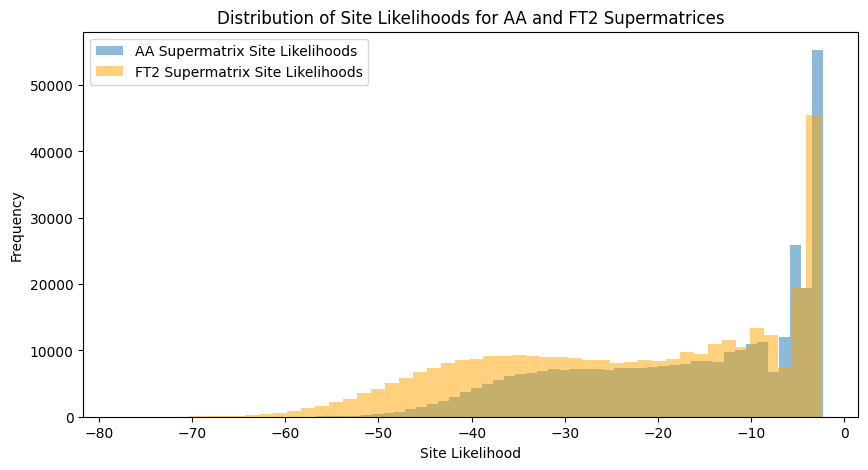

In [192]:
#read a few lines from the site likelihood files
import numpy as np
from matplotlib import pyplot as plt
def read_site_likelihood_file(sitelh_file):
	# read the first line as header
	with open(sitelh_file, 'r') as f:
		header = f.readline().strip().split()
		data = f.readline().split()
		data = [ float(d) for d in data[1:] ]  # Skip the first column (site number)
	return { 'likelihoods': np.array(data) , 'header': header }


#try exponentiating the likelihoods to get probabilities

sl_aa_data = read_site_likelihood_file(sl_aa)
plt.figure(figsize=(10,5))
plt.hist(sl_aa_data['likelihoods'], bins=50, alpha=0.5, label='AA Supermatrix Site Likelihoods')
plt.xlabel('Site Likelihood')
plt.ylabel('Frequency')
sl_ft2_data = read_site_likelihood_file(sl_ft2)
plt.hist(sl_ft2_data['likelihoods'], bins=50, alpha=0.5, label='FT2 Supermatrix Site Likelihoods', color='orange')
plt.title('Distribution of Site Likelihoods for AA and FT2 Supermatrices')
plt.legend()

In [225]:
import os
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import re
from Bio import AlignIO

def create_column_likelihood_dataframe(alignment_file, likelihoods):
	"""
	Calculate site likelihoods for an alignment and create a DataFrame with
	alignment columns and their corresponding likelihood values
	
	Parameters:
	-----------
	alignment_file : str
		Path to the aligned FASTA file
	tree_file : str
		Path to the tree file in Newick format
	output_dir : str or None
		Directory to store intermediate files (defaults to same directory as alignment)
		
	Returns:
	--------
	pandas.DataFrame: DataFrame with columns for site index, alignment column, and likelihood
	"""
	
	# Load the alignment
	aln = read_alignment_file(alignment_file)

	assert len(aln) > 0, "Alignment is empty"
	assert len(aln[0].seq) == len(likelihoods), "Length of likelihoods does not match alignment length"
	# Prepare data for DataFrame
	data = []
	for i in range(len(aln[0].seq)):
		if i < len(likelihoods):
			column = [record.seq[i] for record in aln]
			column_str = ''.join(column)
			data.append({
				'Site': i + 1,
				'Alignment_Column': column_str,
				'Log_Likelihood': likelihoods[i]
			})
	# Create DataFrame
	df = pd.DataFrame(data)
	return df

def character_set(likelihood_df):
	"""
	Determine the character set used in the alignment columns.
	
	Parameters:
	-----------
	likelihood_df : pandas.DataFrame
		DataFrame with 'Alignment_Column' containing alignment columns as strings
		
	Returns:
	--------
	set: Set of unique characters found in the alignment columns
	"""
	char_set = set()
	for col in likelihood_df['Alignment_Column']:
		char_set.update(set(col))
	#remove gap character if present
	if '-' in char_set:
		char_set.remove('-')
	return char_set


"""
def character_frequencies(col , char_set):
	char_count = {}
	total_count = 0
	for char in char_set:
		if char not in char_count and char != '-':
			char_count[char] = 0
		if char != '-':
			char_count[char] += 1
			total_count += 1
		frequencies.update({col: {char: count / total_count for char, count in char_count.items()}})
	return frequencies
"""


def character_freq_columns(likelihood_df):
	"""
	Add columns to the DataFrame for frequencies of each character in the alignment columns.
	
	Parameters:
	-----------
	likelihood_df : pandas.DataFrame
		DataFrame with 'Alignment_Column' containing alignment columns as strings
		
	Returns:
	--------
	pandas.DataFrame: DataFrame with additional columns for character frequencies
	"""
	char_set = character_set(likelihood_df)

	
	likelihood_df = likelihood_df.Alignment_Column.apply(
		lambda col: pd.Series({f'Freq_{char}': col.count(char) / len(col.replace('-', '')) if len(col.replace('-', '')) > 0 else 0 for char in char_set})
	).join(likelihood_df)

	return likelihood_df

def discretize_character_freqs(likelihood_df, bins=5):
	"""
	Discretize character frequency columns into specified number of bins.
	
	Parameters:
	-----------
	likelihood_df : pandas.DataFrame
		DataFrame with character frequency columns
	bins : int
		Number of bins to discretize into (default: 5)
		
	Returns:
	--------
	pandas.DataFrame: DataFrame with discretized frequency columns
	"""
	for col in likelihood_df.columns:
		if col.startswith('Freq_'):
			likelihood_df[f'{col}_binned'] = pd.cut(likelihood_df[col], bins=bins, labels=False)
	return likelihood_df

def discretize_log_likelihoods(likelihood_df, bins=5):
	"""
	Discretize log likelihood values into specified number of bins.
	
	Parameters:
	-----------
	likelihood_df : pandas.DataFrame
		DataFrame with 'Log_Likelihood' column
	bins : int
		Number of bins to discretize into (default: 5)
		
	Returns:
	--------
	pandas.DataFrame: DataFrame with discretized log likelihood column
	"""
	likelihood_df['Log_Likelihood_binned'] = pd.cut(likelihood_df['Log_Likelihood'], bins=bins, labels=False)
	return likelihood_df


In [ ]:

charbins = 5
llbins = 10

#bin log likelihood first with values from both datasets to have same bins

# Create DataFrames for AA and FT2 supermatrix site likelihoods
aa_likelihood_df = create_column_likelihood_dataframe(aa_supermatrix_file, sl_aa_data['likelihoods'] )



aa_likelihood_df = character_freq_columns(aa_likelihood_df)
aa_likelihood_df = discretize_character_freqs(aa_likelihood_df , bins=charbins)
aa_likelihood_df = discretize_log_likelihoods(aa_likelihood_df , bins=llbins)

print( aa_likelihood_df.head() )

ft2_likelihood_df = create_column_likelihood_dataframe(ft2_supermatrix_file, sl_ft2_data['likelihoods'])
ft2_likelihood_df = character_freq_columns(ft2_likelihood_df)
ft2_likelihood_df = discretize_character_freqs(ft2_likelihood_df , bins=charbins)
ft2_likelihood_df = discretize_log_likelihoods(ft2_likelihood_df , bins=llbins)


print( ft2_likelihood_df.head() )

#show hist of discretized log likelihoods
plt.figure(figsize=(10,5))
plt.hist(aa_likelihood_df['Log_Likelihood_binned'].dropna(), bins=charbins, alpha=0.5, label='AA Supermatrix Discretized Log Likelihoods')
plt.hist(ft2_likelihood_df['Log_Likelihood_binned'].dropna(), bins=charbins, alpha=0.5, label='FT2 Supermatrix Discretized Log Likelihoods', color='orange')
plt.xlabel('Binned Log Likelihood')
plt.ylabel('Frequency')
plt.title('Distribution of Discretized Log Likelihoods for AA and FT2 Supermatrices')
plt.legend()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f02308bddf0>>
Traceback (most recent call last):
  File "/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
print(aa_likelihood_df.iloc[0])

Freq_M                                     1.0
Freq_N                                     0.0
Freq_R                                     0.0
Freq_E                                     0.0
Freq_D                                     0.0
Freq_C                                     0.0
Freq_P                                     0.0
Freq_I                                     0.0
Freq_Q                                     0.0
Freq_S                                     0.0
Freq_G                                     0.0
Freq_Y                                     0.0
Freq_V                                     0.0
Freq_H                                     0.0
Freq_L                                     0.0
Freq_F                                     0.0
Freq_W                                     0.0
Freq_T                                     0.0
Freq_K                                     0.0
Freq_A                                     0.0
Site                                         1
Alignment_Col

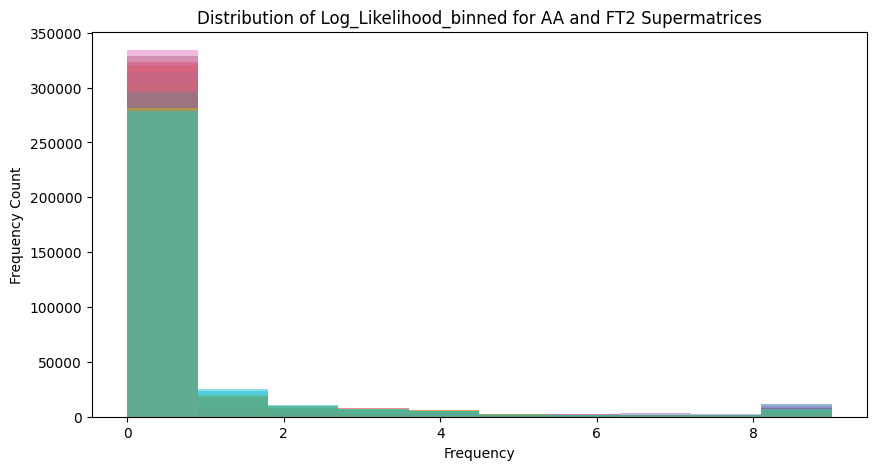

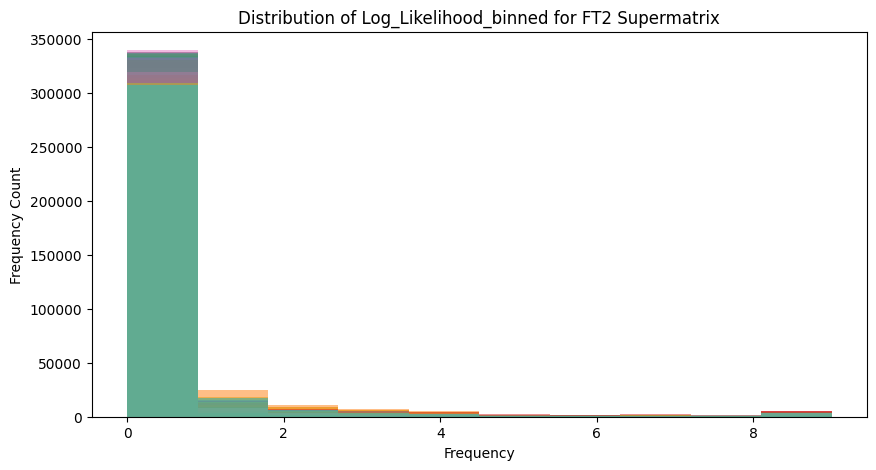

In [221]:
#show some distributions from the character frequency columns for each dataset
count = 0
plt.figure(figsize=(10,5))
for c in aa_likelihood_df.columns:
    if c.startswith('Freq_') and c.endswith('_binned'):
        count += 1
        plt.hist(aa_likelihood_df[c], alpha=0.5, label=f'AA Supermatrix {c}' )
plt.xlabel('Frequency')
plt.ylabel('Frequency Count')
plt.title(f'Distribution of {c} for AA and FT2 Supermatrices')
plt.show()

plt.figure(figsize=(10,5))
count = 0
for c in ft2_likelihood_df.columns:
    if c.startswith('Freq_') and c.endswith('_binned'):
        count += 1
        plt.hist(ft2_likelihood_df[c], alpha=0.5, label=f'FT2 Supermatrix {c}')
plt.xlabel('Frequency')
plt.ylabel('Frequency Count')
plt.title(f'Distribution of {c} for FT2 Supermatrix')
plt.show()


In [222]:
from scipy.stats import entropy
import numpy as np

#concatenate the likelihoods and column proportions
#double integral over the likelihoods and proportions to get MI


def joint_hist_discrete(d1, d2):
	# Compute joint histogram of two discrete variables.
	# d1 and d2 are arrays of discrete values (e.g., binned proportions and binned likelihoods)
	# Make sure d1 and d2 are integers
	d1 = d1.astype(int)
	d2 = d2.astype(int)
	# find unique values and create joint histogram
	unique_d1 = np.unique(d1)
	unique_d2 = np.unique(d2)
	joint_hist = np.zeros( ( len(unique_d1), len(unique_d2) ) , dtype=float)
	for i,n in enumerate(unique_d1):
		for j,m in enumerate(unique_d2):
			#count occurrences
			joint_hist[i, j] = np.sum( (d1 == n) & (d2 == m) )
	joint_prob = joint_hist / joint_hist.sum()
	return joint_prob

def mutual_information(d1, d2):
	# Compute mutual information between two discrete variables.
	# d1 and d2 are arrays of discrete values (e.g., binned proportions and binned likelihoods)
	# Joint histogram
	#make sure d1 and d2 are integers
	joint_hist = joint_hist_discrete(d1, d2)
	# Marginals
	d1_hist = joint_hist.sum(axis=1)
	d2_hist = joint_hist.sum(axis=0)
	d1_prob = d1_hist / d1_hist.sum()
	d2_prob = d2_hist / d2_hist.sum()
	# Compute MI
	mi = 0.0
	for i in range(joint_hist.shape[0]):
		for j in range(joint_hist.shape[1]):
			p_ij = joint_hist[i, j]
			if p_ij > 0:
				mi += p_ij * np.log( p_ij / (d1_prob[i] * d2_prob[j]) )
	return mi


In [223]:
def mutual_information_char_likelihood(likelihood_df):
	"""
	Compute mutual information between character proportions and site likelihoods.

	Parameters:
	-----------
	proportions : array-like
		Proportion values for a character across sites (e.g., column from proportions DataFrame)
	likelihoods : array-like
		Log-likelihood values for corresponding sites
	bins : int
		Number of bins to discretize both variables

	Returns:
	--------
	float: Mutual information (in nats)
	"""
	# Discretize both arrays
	MIs= {}
	likelihoods = likelihood_df['Log_Likelihood_binned'].values	
	for col in likelihood_df.columns:
		if col.startswith('Freq_') and not col.endswith('_binned'):
			proportions = likelihood_df[col].values
			mi = mutual_information(proportions, likelihoods)
			MIs[col] = mi
	return MIs

aa_mi = mutual_information_char_likelihood(aa_likelihood_df)
ft2_mi = mutual_information_char_likelihood(ft2_likelihood_df)
print("Mutual Information for AA Supermatrix:")
#print sum nats
print( sum(aa_mi.values()) )
for char, mi in aa_mi.items():
	print(f"{char}: {mi}")
print("Mutual Information for FT2 Supermatrix:")
print( sum(ft2_mi.values()) )
for char, mi in ft2_mi.items():
	print(f"{char}: {mi}")

Mutual Information for AA Supermatrix:
0.3099098024735481
Freq_M: 0.006163533050944692
Freq_N: 0.02273216346802827
Freq_R: 0.016276845706369045
Freq_E: 0.021036608046491774
Freq_D: 0.02242147922401349
Freq_C: 0.004179489471544221
Freq_P: 0.01828932257116595
Freq_I: 0.012442371646074691
Freq_Q: 0.010779266297525857
Freq_S: 0.019680485600495498
Freq_G: 0.033107372503423015
Freq_Y: 0.00927425406302573
Freq_V: 0.012744685923953177
Freq_H: 0.006995826082407446
Freq_L: 0.023889865670785763
Freq_F: 0.012017504078866176
Freq_W: 0.0033697495179353444
Freq_T: 0.01465662900202991
Freq_K: 0.02043952916823236
Freq_A: 0.019412821380235666
Mutual Information for FT2 Supermatrix:
0.2654934348654554
Freq_7: 0.0015762522929391614
Freq_M: 0.012773216310684938
Freq_0: 0.0012673928543291929
Freq_D: 0.006005546459673543
Freq_C: 0.0034046991885712725
Freq_I: 0.003772667586650454
Freq_S: 0.000618375637623391
Freq_1: 0.009589425194136471
Freq_U: 0.012808874430841565
Freq_O: 0.003917798594484423
Freq_5: 0.00862

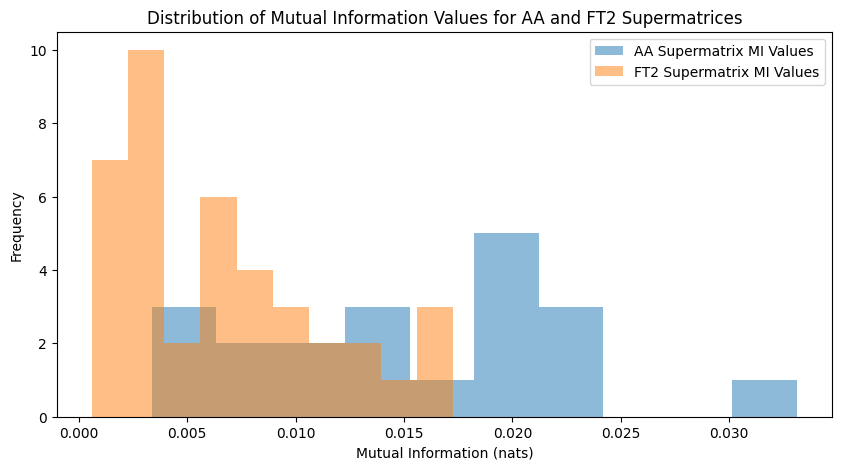

In [224]:
#plot histogram of MI values for each dataset
plt.figure(figsize=(10,5))
plt.hist( list(aa_mi.values()), bins=10, alpha=0.5, label='AA Supermatrix MI Values' )
plt.hist( list(ft2_mi.values()), bins=10, alpha=0.5, label='FT2 Supermatrix MI Values' )
plt.xlabel('Mutual Information (nats)')
plt.ylabel('Frequency')
plt.title('Distribution of Mutual Information Values for AA and FT2 Supermatrices')
plt.legend()